In [1]:
YEAR, EVALUATION = 2022, 1

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML(f'<h1>ANÁLISIS DE LA {EVALUATION}ª EVALUACIÓN</h1>'))
display(HTML(f'<h2>IES Puerto de la Cruz - Telesforo Bravo | Curso {YEAR}-{YEAR + 1}</h2>'))

- [CARGA DE DATOS](#CARGA-DE-DATOS)
- [NÚMERO DE ALUMNADO, PROFESORADO Y RATIOS](#NÚMERO-DE-ALUMNADO,-PROFESORADO-Y-RATIOS)
- [ÉXITO ESCOLAR](#%C3%89XITO-ESCOLAR)
- [ABSENTISMO](#ABSENTISMO)
- [GESTIÓN DE LA CONVIVENCIA](#GESTIÓN-DE-LA-CONVIVENCIA)
- [GRUPOS MÁGICOS](#GRUPOS-MÁGICOS)

In [4]:
import os
import sys
import re
from pathlib import Path

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import colorlover as cl
from IPython.core.display import display, HTML

PROJECT_DIR = Path('../..').resolve()

sys.path.append(str(PROJECT_DIR))
from services import loaders, charts, myplotly, utils

init_notebook_mode(connected=True)

Estilo propio para los dataframes:

In [5]:
with open(PROJECT_DIR / 'custom.css') as f:
    css_rules = ''.join(f.readlines())
HTML('<style>' + css_rules + '</style>')

Deshabilitar el *auto-scrolling* en todo el notebook:

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## CARGA DE DATOS

In [7]:
df, df_bc, labels = loaders.load_data(YEAR, EVALUATION)

In [8]:
df.head()

etapa  éxito  absentismo_justificado  \
curso evaluación grupo                                        
C2021 E1         ESO1A   ESO   30.0                    0.78   
                 ESO1B   ESO   18.2                    3.01   
                 ESO1C   ESO   42.9                    1.35   
                 ESO1D   ESO   25.0                    2.75   
                 ESO2A   ESO   52.2                    2.35   

                        absentismo_injustificado  partes  \
curso evaluación grupo                                     
C2021 E1         ESO1A                      3.05     4.0   
                 ESO1B                      1.19     1.0   
                 ESO1C                      5.39    14.0   
                 ESO1D                      4.71    22.0   
                 ESO2A                      6.66     4.0   

                        suspensión_asistencia  ratio  absentismo  éxito_abs  \
curso evaluación grupo                                                        
C2021 E1         ESO1A                    0.0   20.0        3.83        6.0   
                 ESO1B                    0.0   22.0        4.20        4.0   
                 ESO1C                    0.0   21.0        6.74        9.0   
                 ESO1D                    2.0   20.0        7.46        5.0   
                 ESO2A                    0.0   23.0        9.01       12.0   

                            ccbb  max_ratio  
curso evaluación grupo                       
C2021 E1         ESO1A  4.553571         30  
                 ESO1B  4.767857         30  
                 ESO1C  4.907143         30  
                 ESO1D  4.339286         30  
                 ESO2A  5.350000         30

In [9]:
df_bc.head()

nivel  item  PA  AD  MA  EX  marca
curso evaluación grupo                                   
C2021 E1         ESO1A  1ESO    CL  40  45  15   0  4.375
                 ESO1A  1ESO  CMCT  65  25  10   0  3.625
                 ESO1A  1ESO    CD  40  40  20   0  4.500
                 ESO1A  1ESO   AAP  30  55  15   0  4.625
                 ESO1A  1ESO   CSC  20  65  15   0  4.875

In [10]:
# recurrent variables
stages = df['etapa'].unique()
years = df.index.levels[0]
current_year, current_eval = labels[-1]

In [11]:
# dataframe for current year and evaluation
dfc = df.loc[labels[-1]]
dfc_bc = df_bc.loc[labels[-1]]

In [12]:
# dataframe for comparisons with last evaluation
df_comp = dfc.merge(df.loc[labels[-2]], left_index=True, right_index=True)

df_bc_last_eval_new_index = df_bc.loc[labels[-2]].reset_index().set_index(['grupo', 'item'])
dfc_bc_new_index = dfc_bc.reset_index().set_index(['grupo', 'item'])
df_bc_comp = dfc_bc_new_index.merge(df_bc_last_eval_new_index, left_index=True, right_index=True)
df_bc_comp = df_bc_comp.reset_index().set_index(['grupo'])

# NÚMERO DE ALUMNADO, PROFESORADO Y RATIOS

In [13]:
# filter for current evaluation
df_ce = df.xs(current_eval, level='evaluación')

## Evolución del número total de alumnado y profesorado

In [14]:
extra_historic_year = loaders.get_year_label(YEAR - 3)

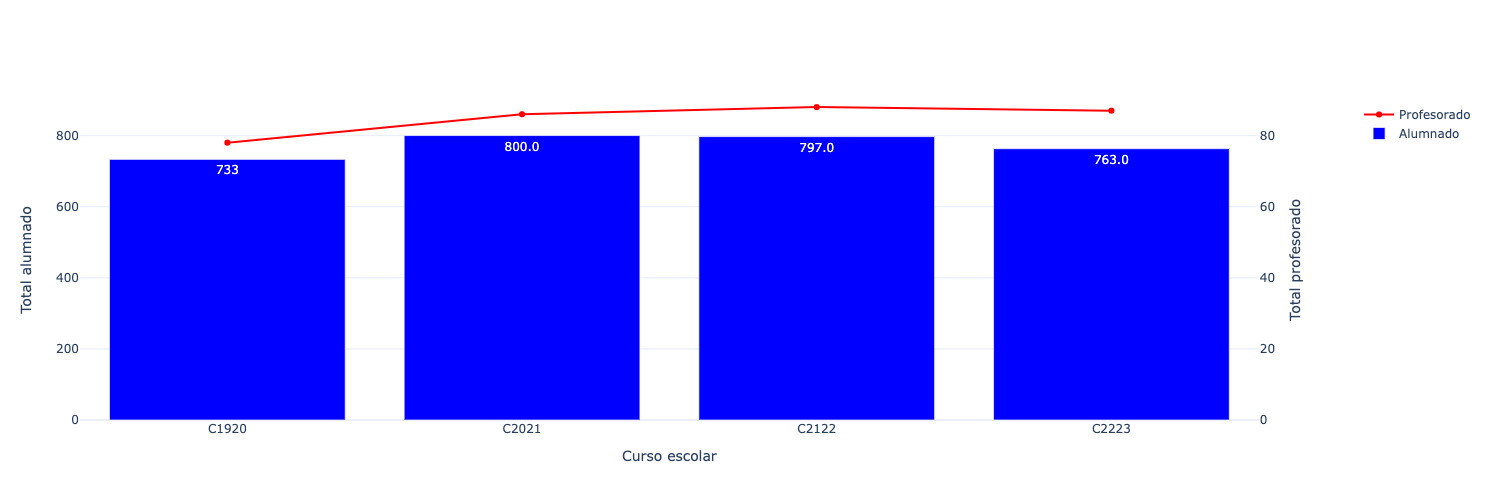

In [15]:
#e1=df.query(f'evaluación == "E1"').groupby('curso').agg({'ratio': 'sum'})['ratio'].values
#e2=df.query(f'evaluación == "E2"').groupby('curso').agg({'ratio': 'sum'})['ratio'].values
#e3=df.query(f'evaluación == "E3"').groupby('curso').agg({'ratio': 'sum'})['ratio'].values
years_aux    = [extra_historic_year] + list(years)       # Vamos a añadir un año extra a la comparativa
students     = [ 733 ] + list(df.query(f'evaluación == "{labels[-1][1]}"').groupby('curso').agg({'ratio': 'sum'})['ratio'].values)             
teachers     = (      78,  86, 88, 87)      # Valores de profesorado extraídos de Tifón: 2011/12:70, 2012/13:68, 2013/14:68, 2015/16:70, 2016/17:69, 2017/18:71, 2018/19:70, 2019/20:78, 2020/21:86, 2021/22:88, 2022/23:87
if EVALUATION == 1:
    myplotly.total_students_teachers_evolution(students, teachers, years_aux)
else:
    students_dam = (      0,   0,   0,  47)      # Estudiantes a resaltar en cada curso (se restan al global)
    myplotly.total_students_teachers_evolution(students, teachers, years_aux, students_diff=(students_dam, 'Estudiantes DAM'))

## Evolución del número de alumnado por etapas y evaluaciones

In [16]:
if EVALUATION == 3:
    myplotly.num_students_evolution_evaluations(df, [], years[-1]) 
    myplotly.num_students_evolution_evaluations(df, stages, years[-1], total=False) 
    series = {"ESO": [17], "BACH": [16], "FPB": [8], "CFGM": [25], "CFGS": [70]} # Datos 2021/22 Ekade >> Matrículas >> Relación de Matrículas (sólo matrículas finalizadas)
    myplotly.cbar(["Número de bajas de matrícula"], series, is_percentage=False, barmode="stack")

## Evolución del número total de alumnado por niveles

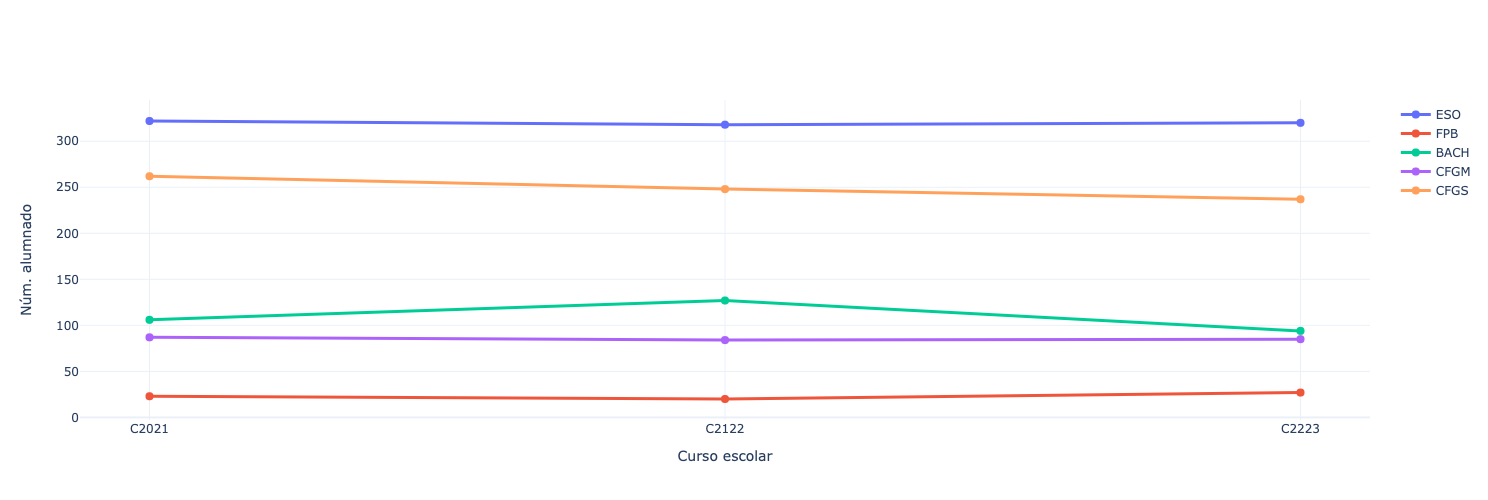

In [17]:
myplotly.num_students_evolution(df_ce, stages, years)

## Evolución de la ratio de alumnado por etapas (media)

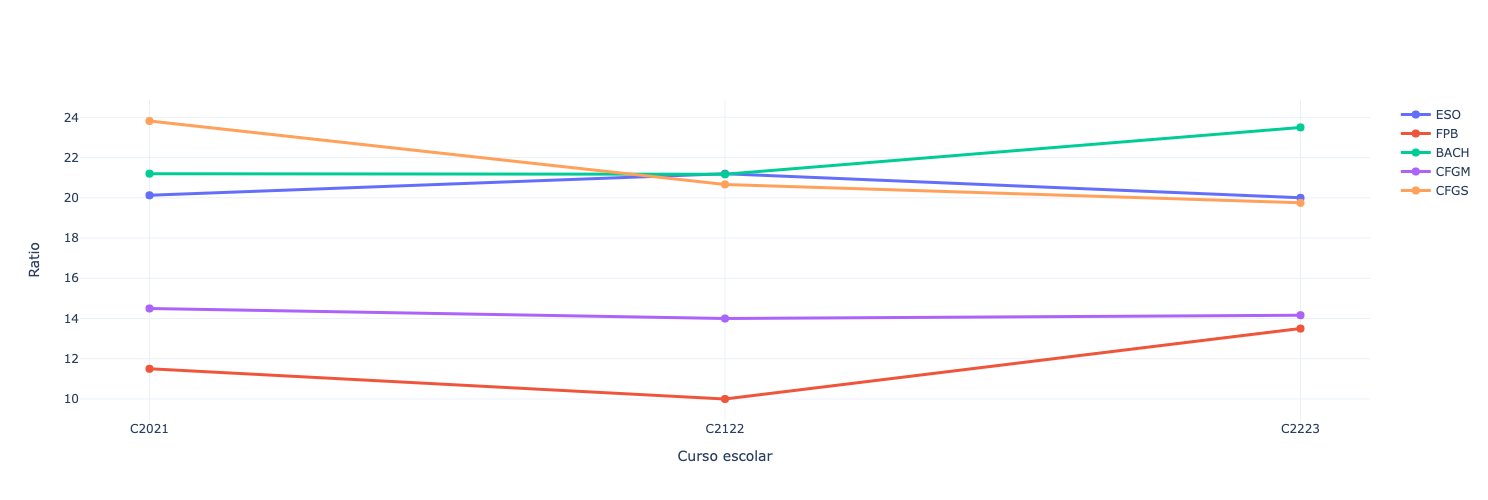

In [18]:
myplotly.num_students_evolution(df_ce, stages, years, ratio=True)

## Evolución de la ratio de alumnado por etapas (máximo)

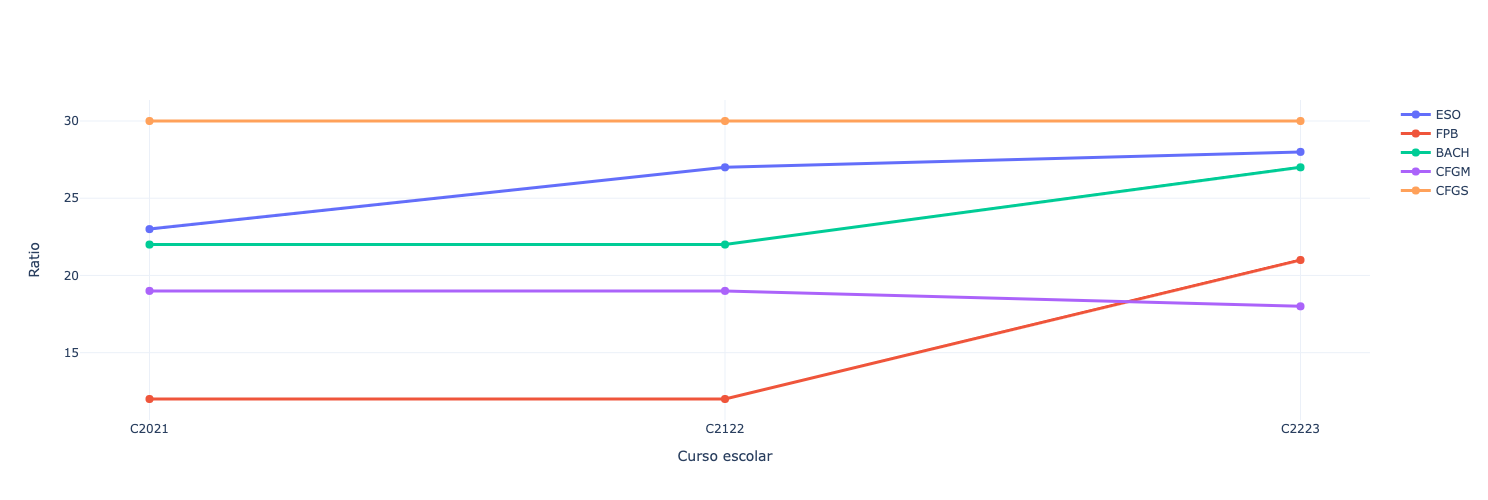

In [19]:
myplotly.num_students_evolution(df_ce, stages, years, ratio=True, max_ratio=True)

## Evolución del número de grupos totales

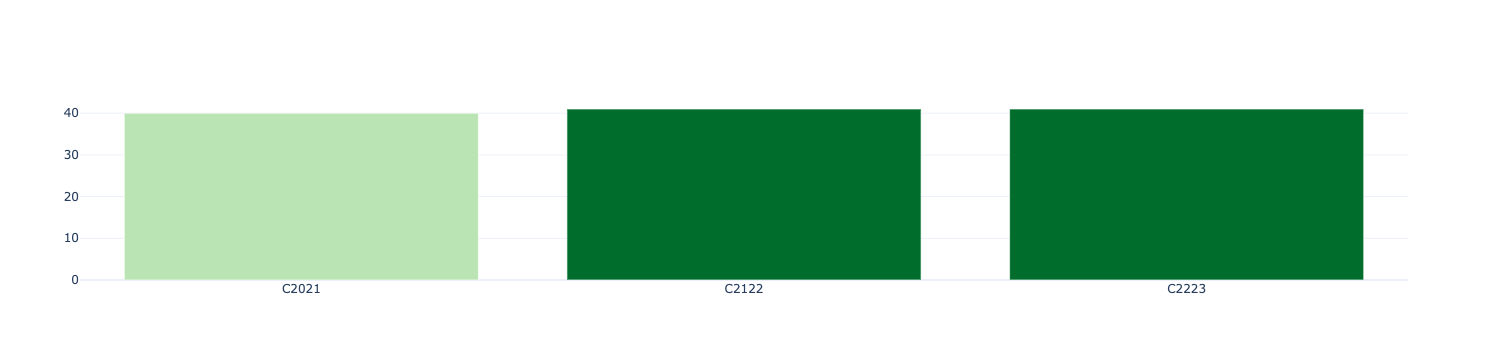

In [20]:
series = []
for year in years:
    series.append(df.query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['etapa'].count())

myplotly.bar_simple(years, series, is_percentage=False)

## Evolución del número de grupos por etapas

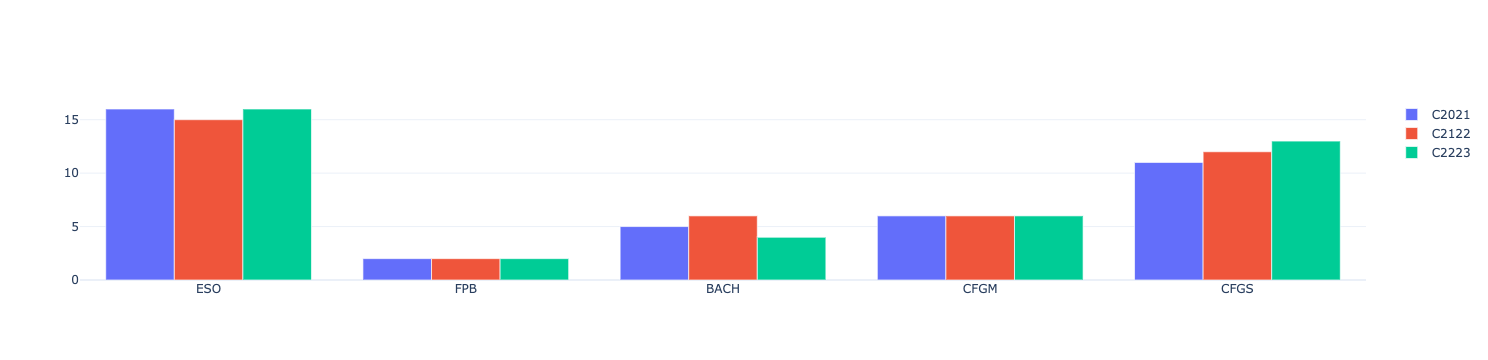

In [21]:
series = {}
for year in years:
    series[year] = []
    for stage in stages:
        series[year].append(df.query(f'etapa == "{stage}" & curso == "{year}" & evaluación == "{labels[-1][1]}"')['etapa'].count())

myplotly.cbar(stages, series, is_percentage=False)

## Evolución del número de grupos en ESO y Bachillerato

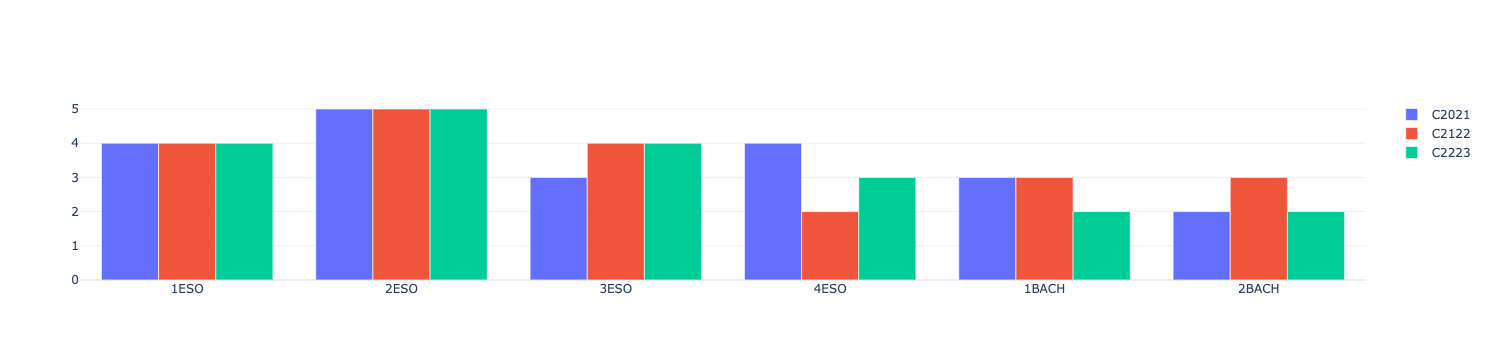

In [22]:
etapas_niveles = {'ESO': 4, 'BACH': 2}
series = {}
titles = []
no_titles = True
for year in years:
    series[year] = []
    for etapa in etapas_niveles:
        for num in range(etapas_niveles[etapa]):
            series[year].append(df.query(f'grupo.str.contains("{num+1}") & etapa == "{etapa}" & curso == "{year}" & evaluación == "{labels[-1][1]}"', engine="python").count()['etapa'])
            if no_titles:
                titles.append(str(num+1)+etapa)
    no_titles = False

myplotly.cbar(titles, series, is_percentage=False)


## Nivel de ocupación por grupos

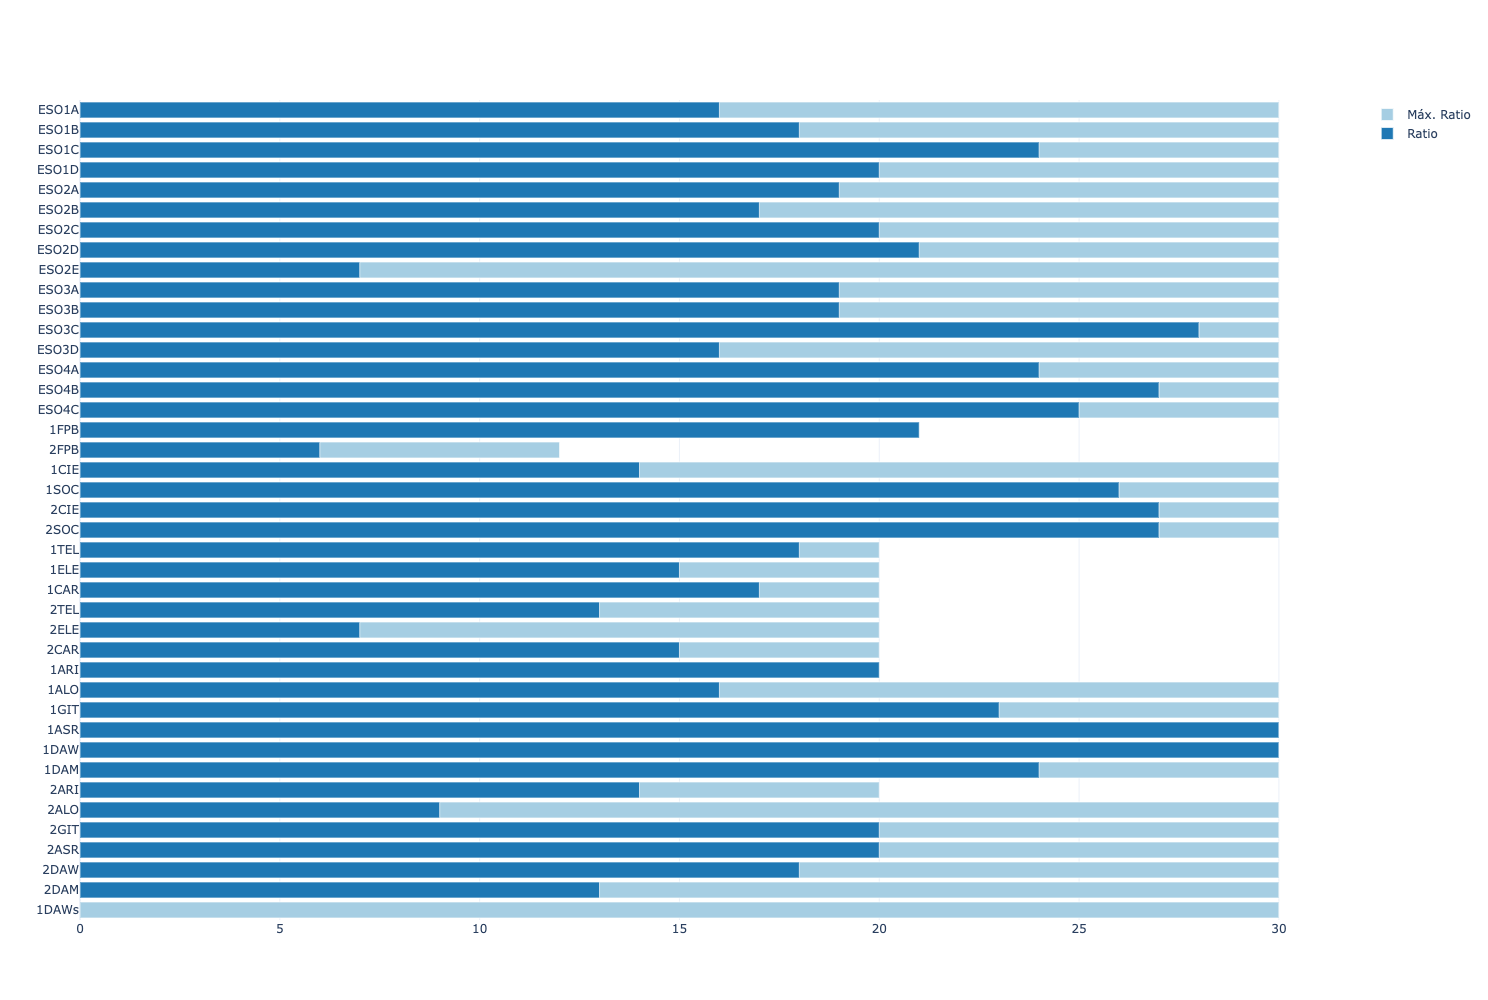

In [87]:
myplotly.hbar((dfc['max_ratio'], dfc['ratio']), dfc.index, trace_names=('Máx. Ratio', 'Ratio'))

# ÉXITO ESCOLAR

<div class="alert alert-success" role="alert">
    ÉXITO ESCOLAR = <b>0 suspensos</b>
</div>

## ÉXITO EN VALORES ABSOLUTOS

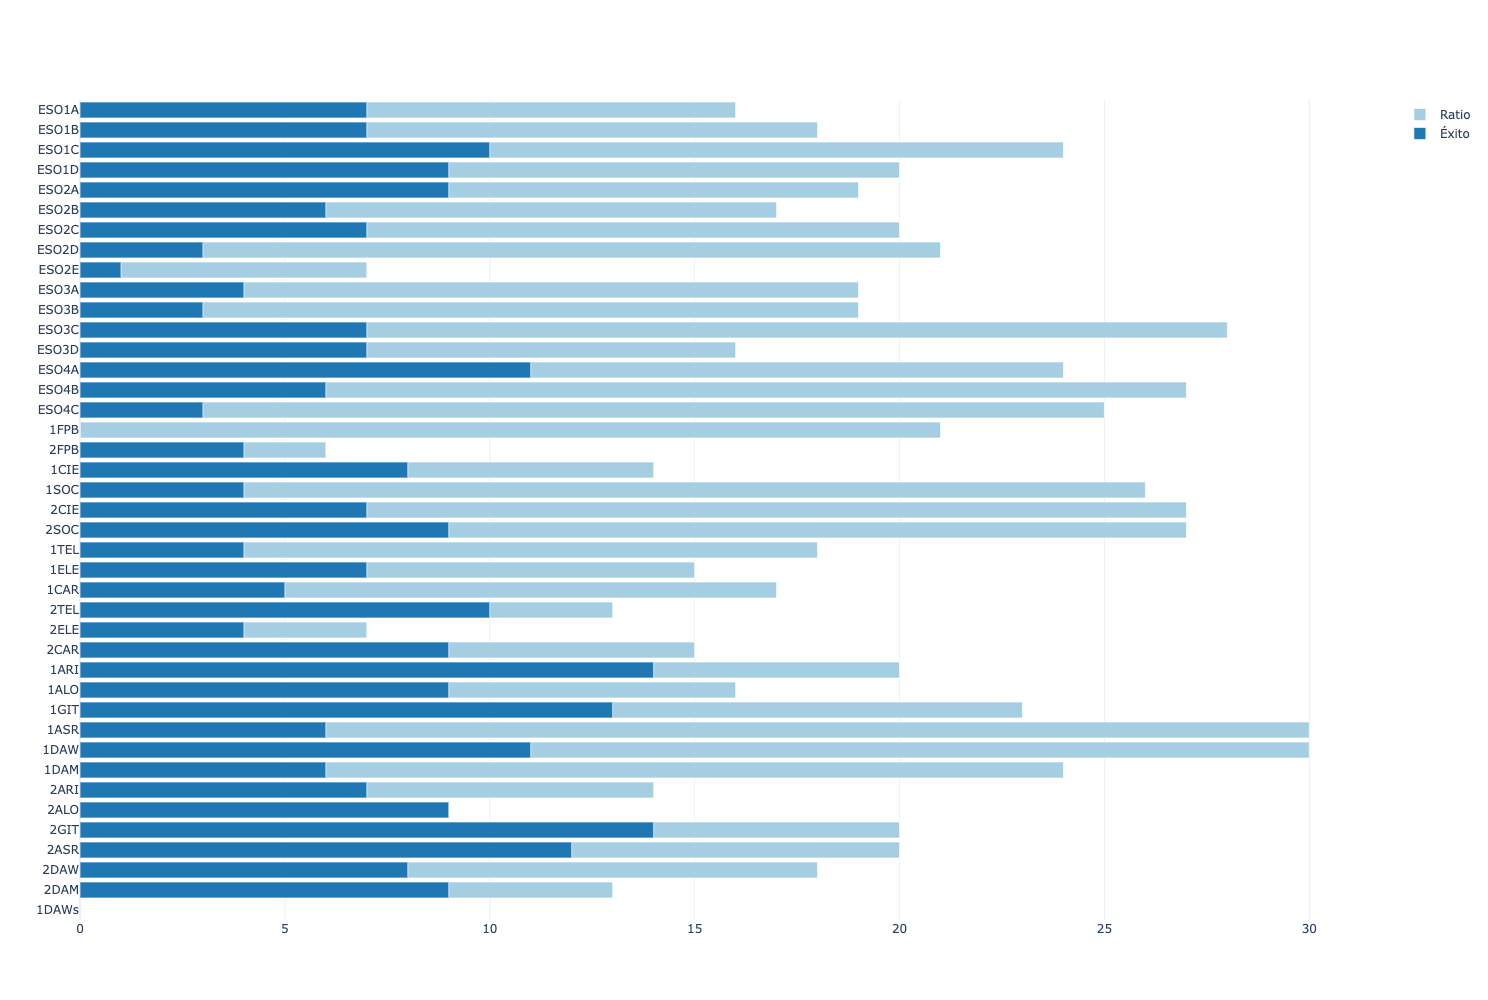

In [25]:
myplotly.hbar((dfc['ratio'], dfc['éxito_abs']), dfc.index, trace_names=('Ratio', 'Éxito'))

## ESO

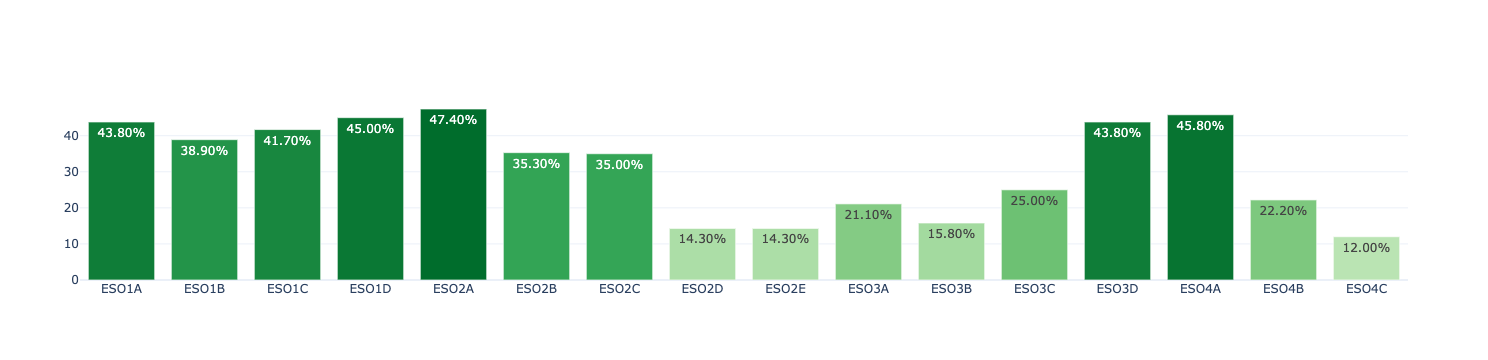

In [26]:
dfc_ESO = loaders.get_data_by_stages(dfc, 'ESO')
myplotly.bar_simple(dfc_ESO.index, dfc_ESO['éxito'])

In [27]:
dfc_ESO.mean()

éxito                       31.337500
absentismo_justificado       2.720000
absentismo_injustificado     6.500000
partes                       2.562500
suspensión_asistencia        1.562500
ratio                       20.000000
absentismo                   9.220000
éxito_abs                    6.250000
ccbb                         4.313839
max_ratio                   30.000000
dtype: float64

## FPB

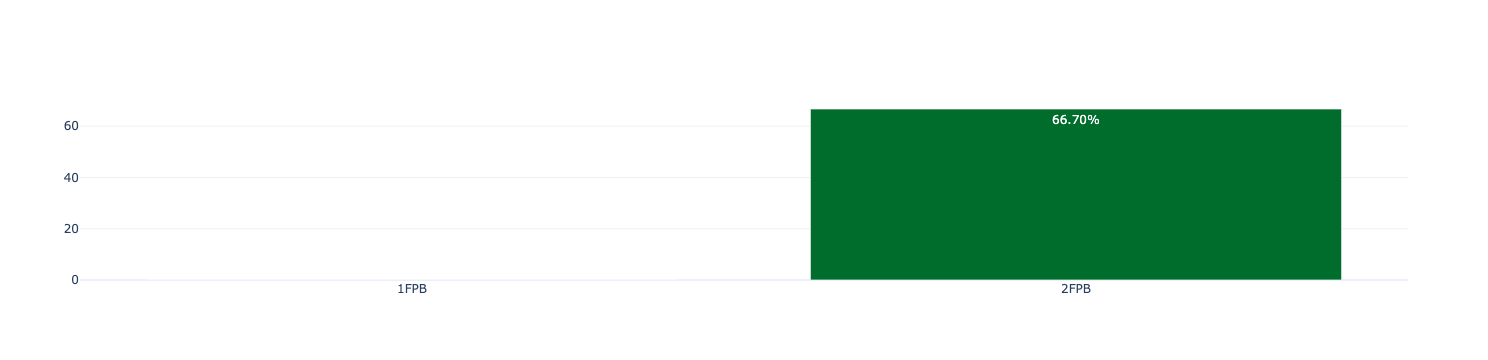

In [28]:
dfc_FPB = loaders.get_data_by_stages(dfc, 'FPB')
myplotly.bar_simple(dfc_FPB.index, dfc_FPB['éxito'])

In [29]:
dfc_FPB.mean()

éxito                       33.350
absentismo_justificado       7.650
absentismo_injustificado    25.025
partes                      10.000
suspensión_asistencia       13.000
ratio                       13.500
absentismo                  32.675
éxito_abs                    2.000
ccbb                           NaN
max_ratio                   12.000
dtype: float64

## BACHILLERATO

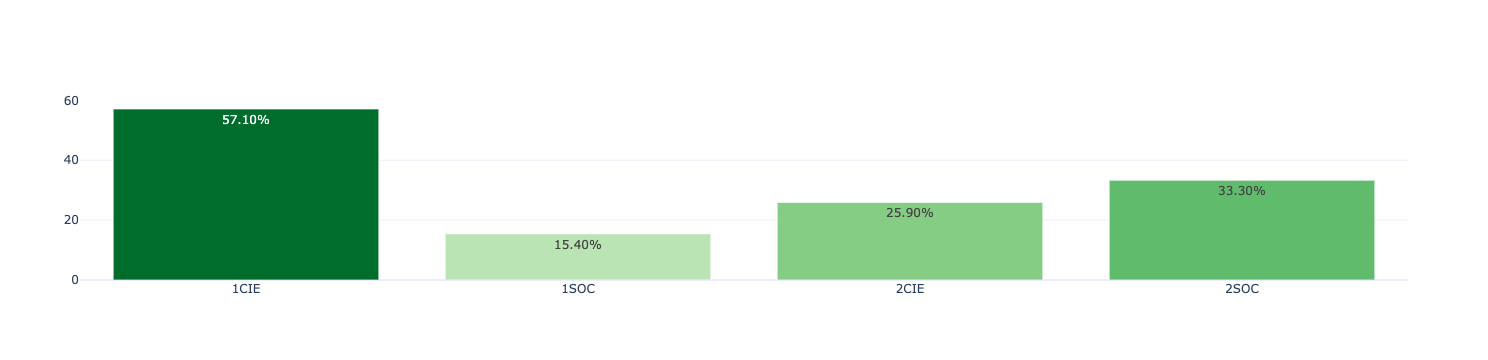

In [30]:
dfc_BACH = loaders.get_data_by_stages(dfc, 'BACH')
myplotly.bar_simple(dfc_BACH.index, dfc_BACH['éxito'])

In [31]:
dfc_BACH.mean()

éxito                       32.9250
absentismo_justificado       2.5475
absentismo_injustificado     6.6050
partes                       2.5000
suspensión_asistencia        2.2500
ratio                       23.5000
absentismo                   9.1525
éxito_abs                    7.0000
ccbb                            NaN
max_ratio                   30.0000
dtype: float64

## CICLOS FORMATIVOS DE GRADO MEDIO

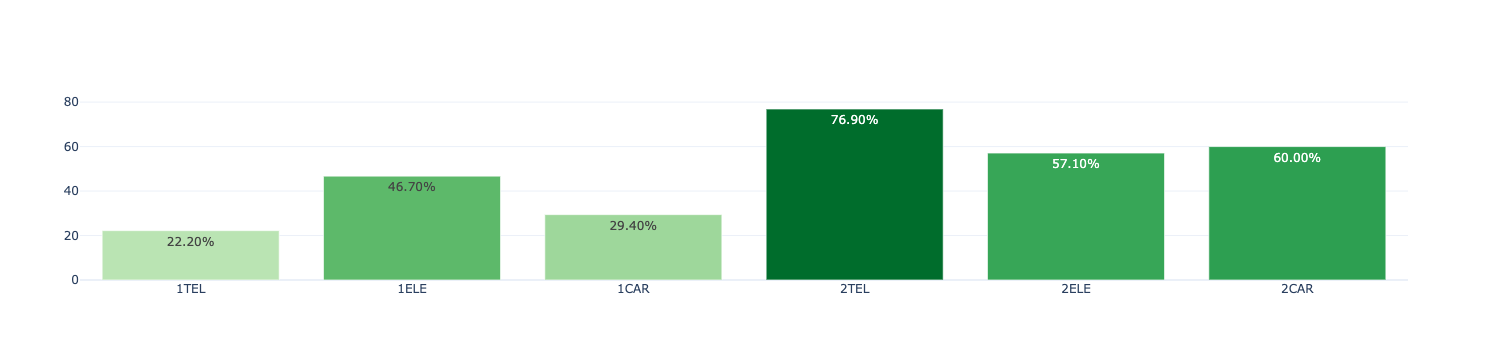

In [32]:
dfc_CFGM = loaders.get_data_by_stages(dfc, 'CFGM')
myplotly.bar_simple(dfc_CFGM.index, dfc_CFGM['éxito'])

In [33]:
dfc_CFGM.mean()

éxito                       48.716667
absentismo_justificado       2.591667
absentismo_injustificado    15.610000
partes                       0.166667
suspensión_asistencia        0.166667
ratio                       14.166667
absentismo                  18.201667
éxito_abs                    6.500000
ccbb                              NaN
max_ratio                   20.000000
dtype: float64

## CICLOS FORMATIVOS DE GRADO SUPERIOR

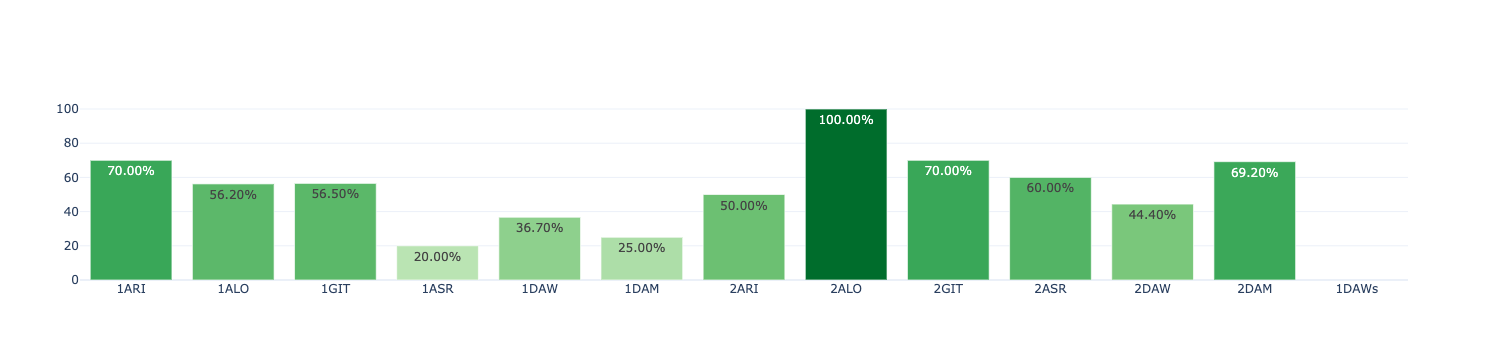

In [34]:
dfc_CFGS = loaders.get_data_by_stages(dfc, 'CFGS')
myplotly.bar_simple(dfc_CFGS.index, dfc_CFGS['éxito'])

In [35]:
dfc_CFGS.mean()

éxito                       54.833333
absentismo_justificado       2.814615
absentismo_injustificado     9.910769
partes                       0.000000
suspensión_asistencia        0.000000
ratio                       19.750000
absentismo                  12.725385
éxito_abs                    9.833333
ccbb                              NaN
max_ratio                   28.461538
dtype: float64

## GLOBAL

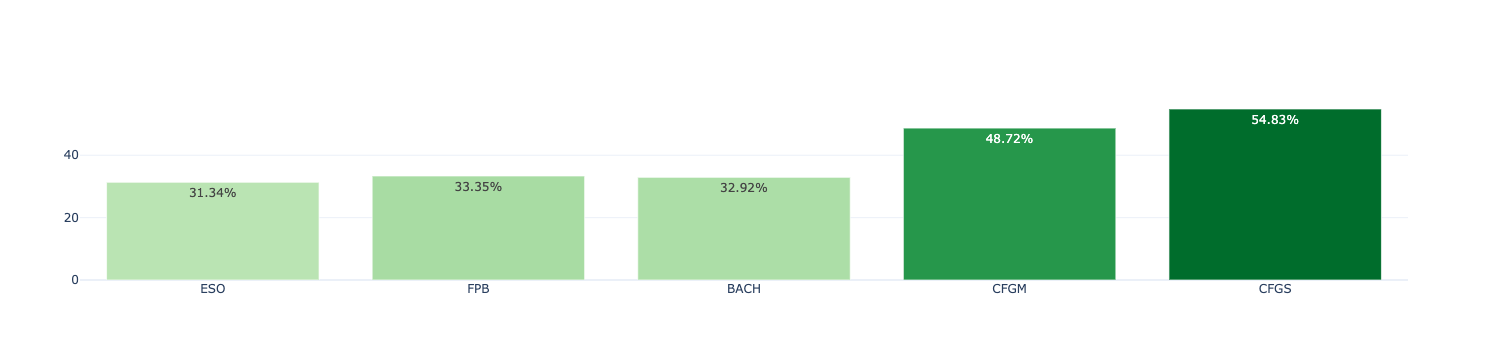

In [36]:
dfc_summary = dfc.groupby('etapa').mean().loc[stages]
myplotly.bar_simple(dfc_summary.index, dfc_summary['éxito'])

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

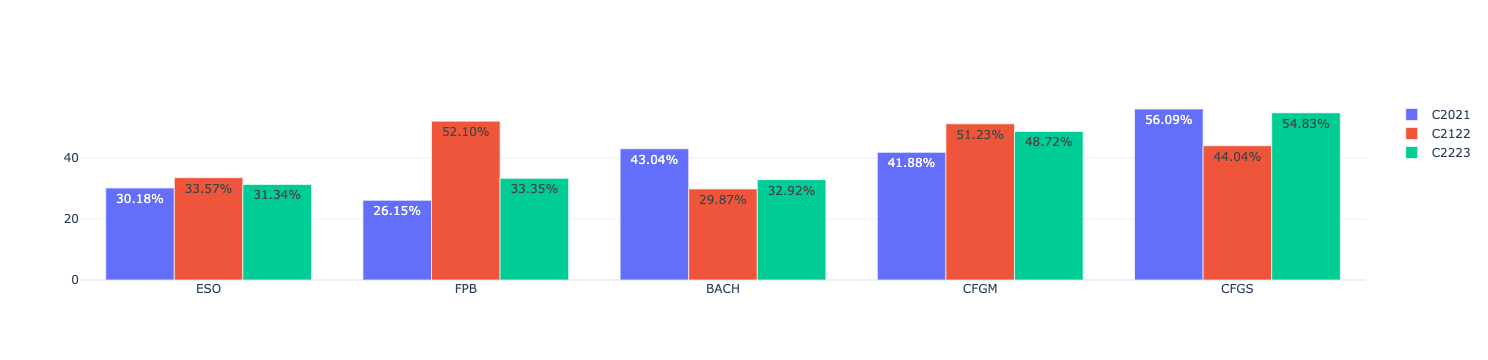

In [37]:
aux = df.groupby(['etapa', 'curso', 'evaluación']).mean().reset_index().set_index('etapa')
series = {year: aux.loc[stages].query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['éxito'].values
          for year in years}

myplotly.cbar(stages, series)

In [38]:
mean_success = dfc['éxito'].mean()
display(HTML(f'''
<div class='alert alert-info' role="alert">
    Éxito global medio: <b>{mean_success:.2f}</b>%
</div>
'''))

In [39]:
if EVALUATION > 1:
    display(HTML('<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR</h2>'))

    aux = df_comp['éxito_x'] - df_comp['éxito_y']
    myplotly.dbar(aux.index, aux)

## COMPETENCIAS BÁSICAS

**AAP**: Aprender a aprender.  
**CD**: Competencia digital.  
**CEC**: Conciencia y expresiones culturales.  
**CL**: Comunicación lingüística.  
**CMCT**: Competencia matemática y competencias básicas en ciencia y tecnología.  
**CSC**: Competencias sociales y cívicas.  
**SIEE**: Sentido de iniciativa y espíritu emprendedor.  

#### Valor resumen por competencia básica:
\begin{equation}
MARCA = 0.025 * \mathbb{PA} + 0.050 * \mathbb{AD} + 0.075 * \mathbb{MA} + 0.1 * \mathbb{EX}
\end{equation}

, donde $\mathbb{PA}$, $\mathbb{AD}$, $\mathbb{MA}$ y $\mathbb{EX}$ son los porcentajes de adquisición de la competencia básica en cuestión.

### ESTUDIO POR NIVELES Y COMPETENCIA

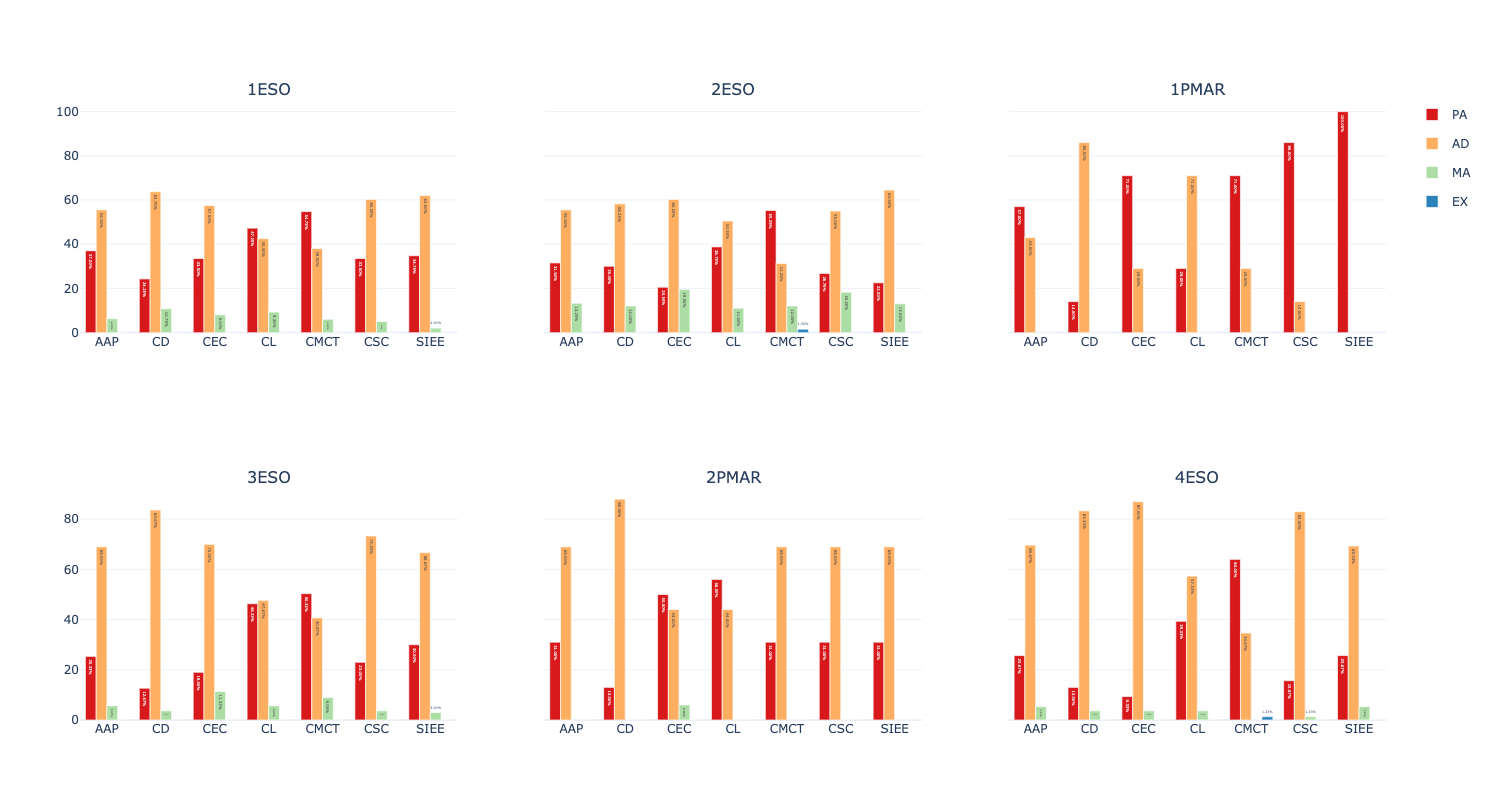

In [40]:
myplotly.bc_bar(dfc_bc)

## Análisis simplificado por competencias básicas

In [41]:
dfc_bc_marked = dfc_bc.groupby(['nivel', 'item']).mean().reset_index().pivot('item', 'nivel', 'marca')

In [42]:
dfc_bc_marked.max()

nivel
1ESO     4.600000
1PMAR    4.650000
2ESO     4.987500
2PMAR    4.725000
3ESO     4.825000
4ESO     4.858333
dtype: float64

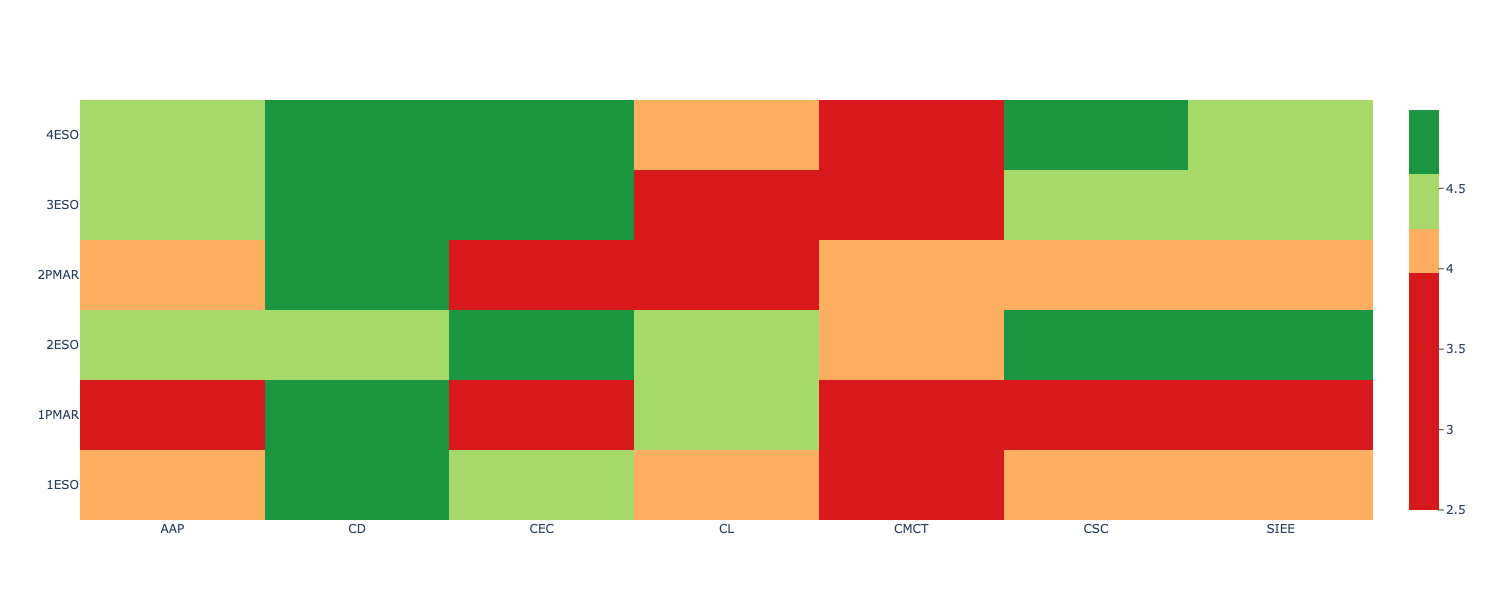

In [43]:
colors = cl.scales['4']['div']['RdYlGn']
q1 = np.quantile(dfc_bc_marked.values, q=0.25)
q2 = np.quantile(dfc_bc_marked.values, q=0.5)
q3 = np.quantile(dfc_bc_marked.values, q=0.75)
new_thresholds = [q1, q2, q3]
thresholds = utils.normalize_thresholds(dfc_bc_marked, new_thresholds)
colorscale = utils.make_colorscale(colors, thresholds, discrete=True)

myplotly.heatmap(dfc_bc_marked.index, dfc_bc_marked.columns, dfc_bc_marked.values.T, colorscale)

### Nivel competencial resumen por nivel

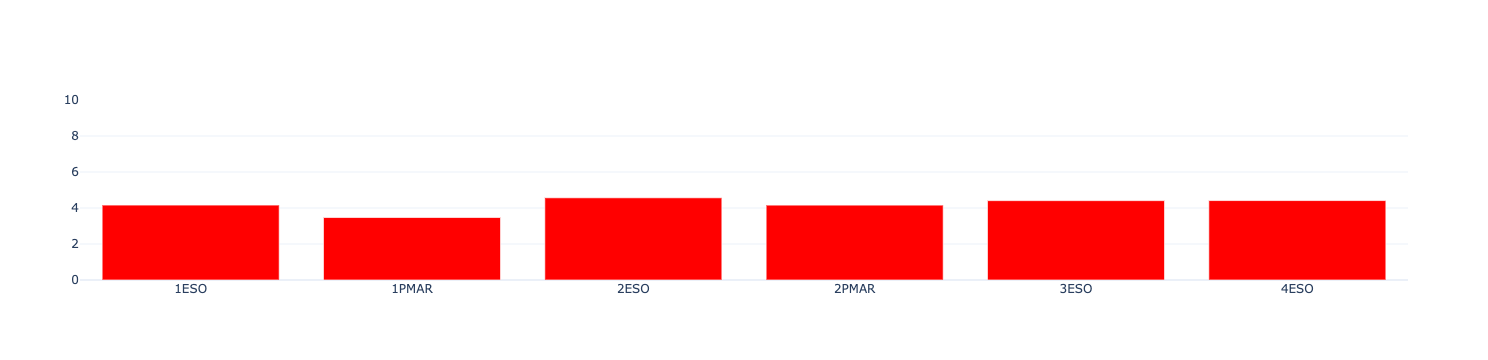

In [44]:
aux = dfc_bc['marca'].groupby(dfc_bc['nivel']).mean()
myplotly.bar_simple(aux.index, aux, is_percentage=False, yaxis_range=[0, 10], mark_colors=True)

### Nivel competencial resumen por competencias básicas

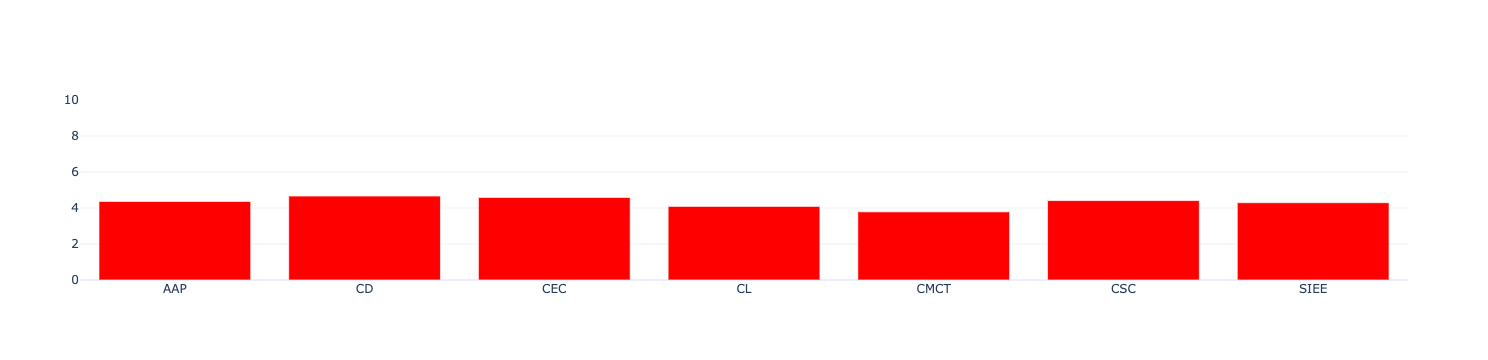

In [45]:
aux = dfc_bc['marca'].groupby(dfc_bc['item']).mean()
myplotly.bar_simple(aux.index, aux, is_percentage=False, yaxis_range=[0, 10], mark_colors=True)

### Máximo nivel competencial

In [46]:
dfc_bc.iloc[dfc_bc.reset_index()['marca'].idxmax()][['item', 'marca']]

item     CEC
marca    5.8
Name: ESO2A, dtype: object

### Mínimo nivel competencial

In [47]:
dfc_bc.iloc[dfc_bc.reset_index()['marca'].idxmin()][['item', 'marca']]

item     SIEE
marca     2.5
Name: ESO2E, dtype: object

## Evolución de los niveles competenciales

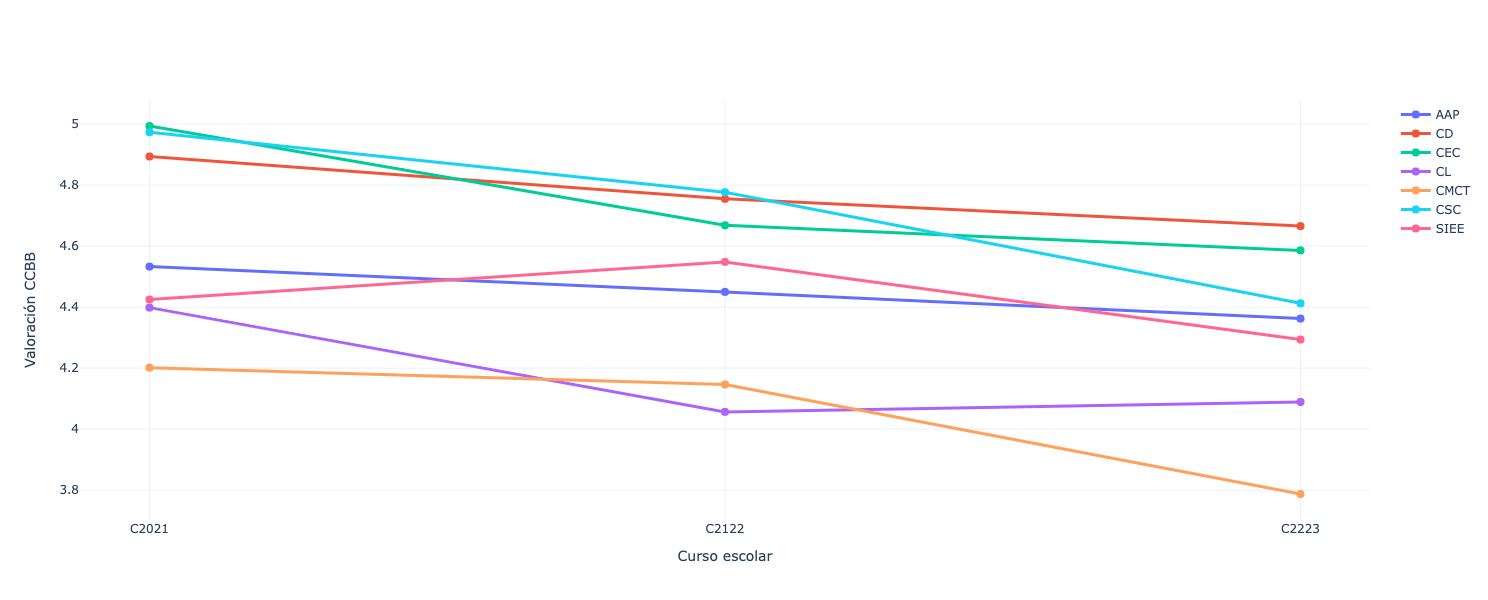

In [48]:
# filter by evaluation
df_bc_same_eval = df_bc.xs(labels[-1][1], level='evaluación')
myplotly.bc_evolution(df_bc_same_eval)

In [49]:
if EVALUATION > 1:
    display(HTML('<h2>Evolución competencial con respecto a la evaluación anterior</h2>'))
    myplotly.bc_diff(df_bc_comp)

## Correlación entre competencias básicas

> Se considera que dos variables cuantitativas están correlacionadas cuando los valores de una de ellas varían sistemáticamente con respecto a los valores homónimos de la otra: si tenemos dos variables (A y B) existe correlación entre ellas si al disminuir los valores de A lo hacen también los de B y viceversa. La correlación entre dos variables no implica, por sí misma, ninguna relación de causalidad.

Fuente: [Wikipedia](https://es.wikipedia.org/wiki/Correlaci%C3%B3n)

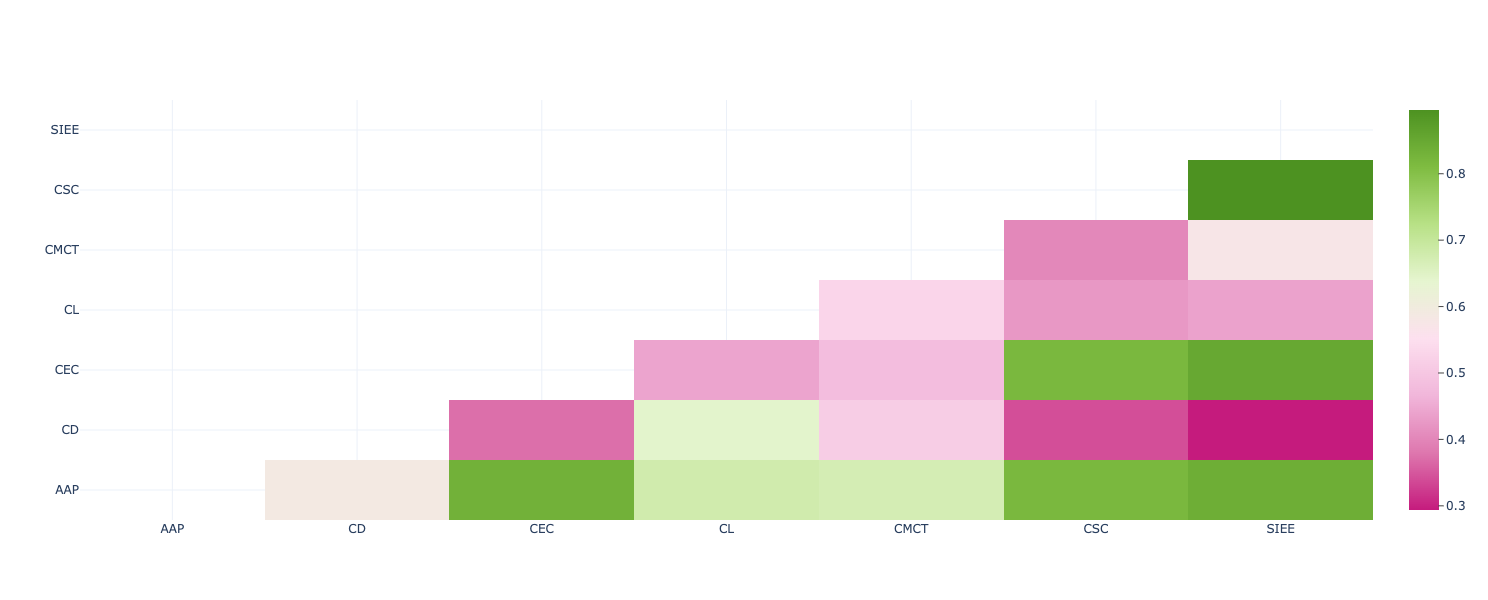

In [50]:
aux = dfc_bc.reset_index().pivot(index='grupo', columns='item', values='marca').corr()
aux.values[np.triu_indices(aux.shape[0])] = np.NaN

colorscale = utils.make_colorscale(cl.scales['8']['div']['PiYG'])
myplotly.heatmap(aux.index, aux.columns, aux.values.T, colorscale=colorscale)

## Mejores y peores valoraciones de competencias básicas por grupo

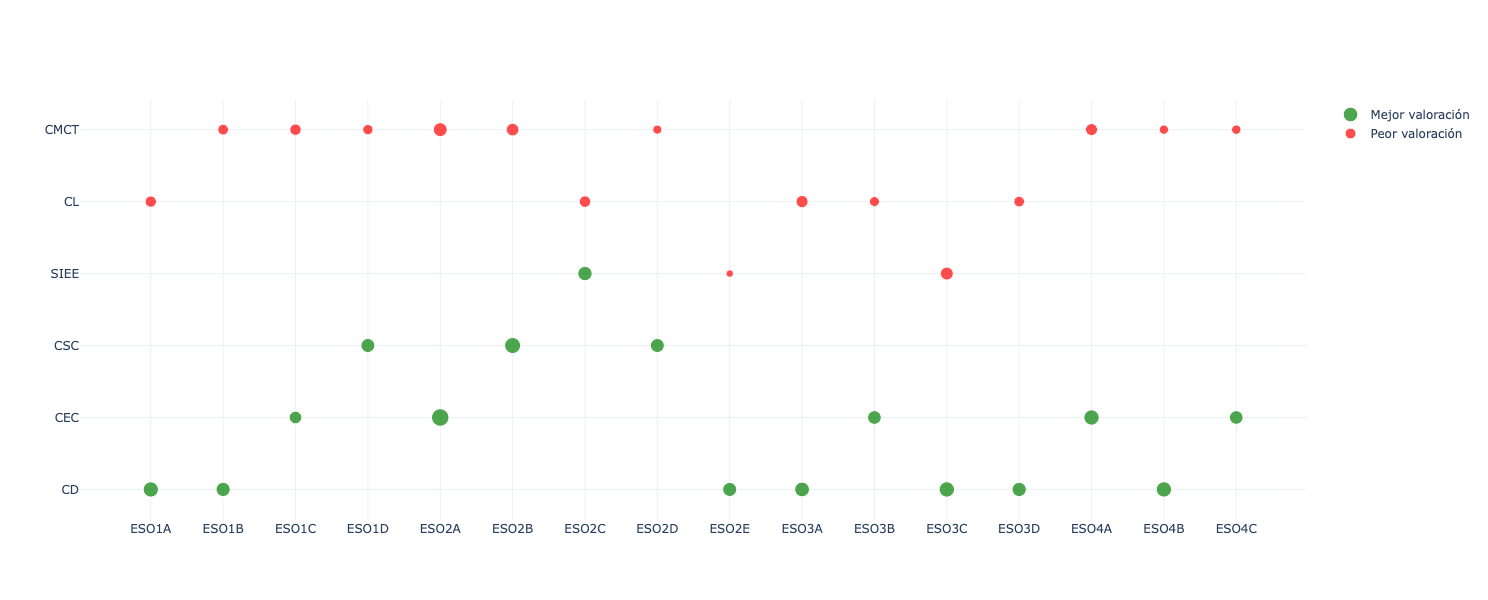

In [51]:
myplotly.bc_extremes(dfc_bc)

# ABSENTISMO

<div class="alert alert-success" role="alert">
    ABSENTISMO = <b>Faltas justificadas + Faltas injustificadas</b>
</div>

**Se va a estudiar el ABSENTISMO ACUMULADO desde el 1 de septiembre hasta la fecha de finalización del trimestre de análisis.**

## ABSENTISMO TOTAL vs ABSENTISMO JUSTIFICADO

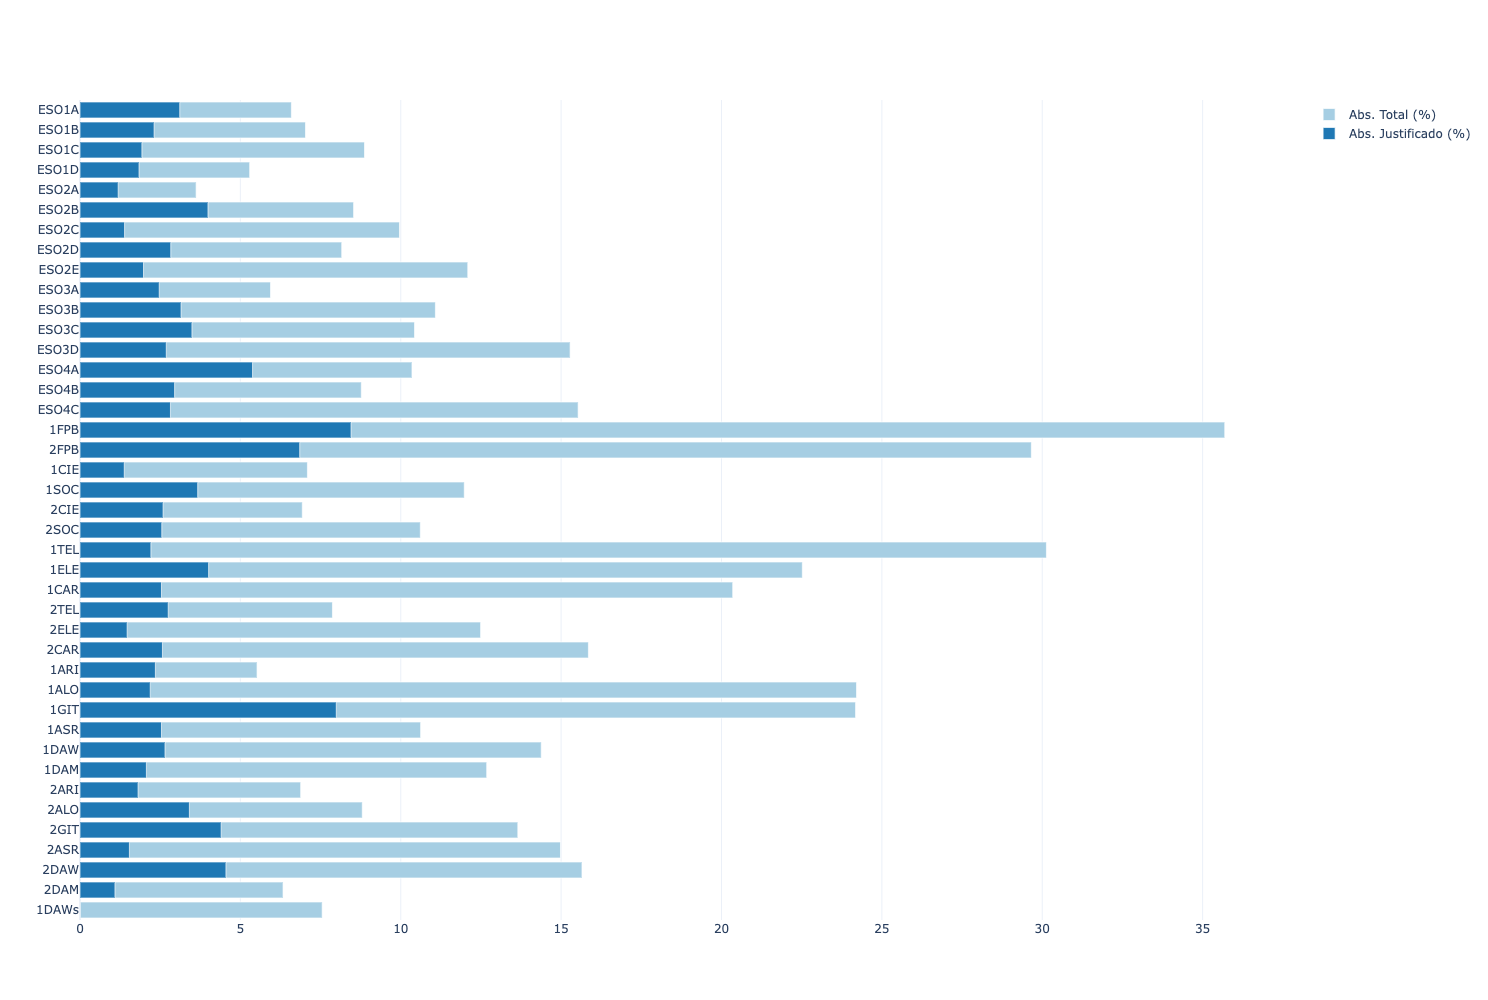

In [52]:
myplotly.hbar((dfc['absentismo'], dfc['absentismo_justificado']), dfc.index,
              trace_names=('Abs. Total (%)', 'Abs. Justificado (%)'))

## ESO

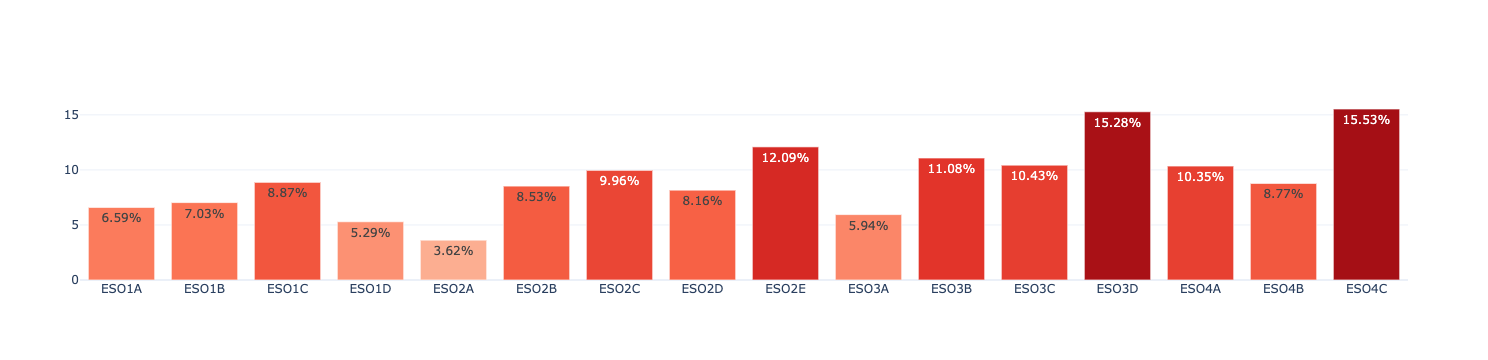

In [53]:
myplotly.bar_simple(dfc_ESO.index, dfc_ESO['absentismo'], colormap='Reds')

# FPB

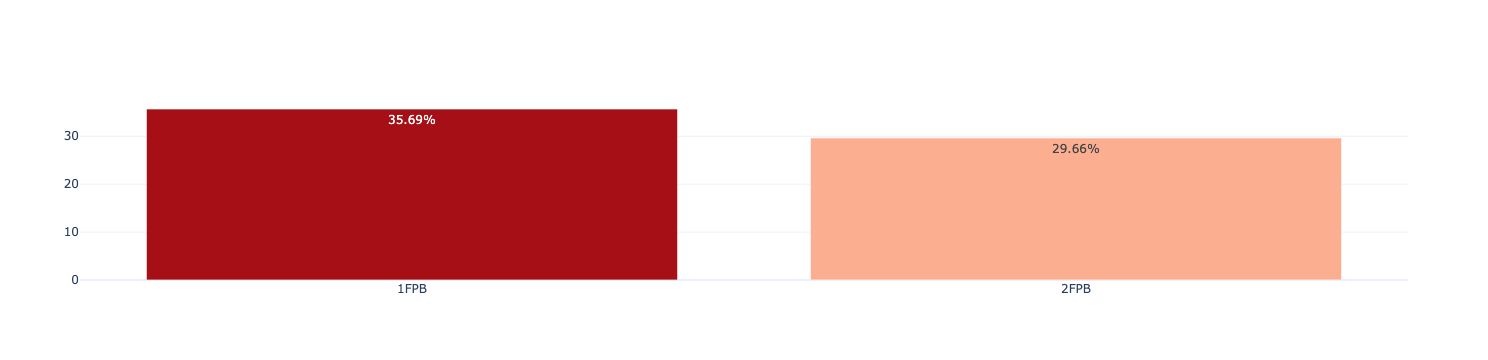

In [54]:
myplotly.bar_simple(dfc_FPB.index, dfc_FPB['absentismo'], colormap='Reds')

## BACHILLERATO

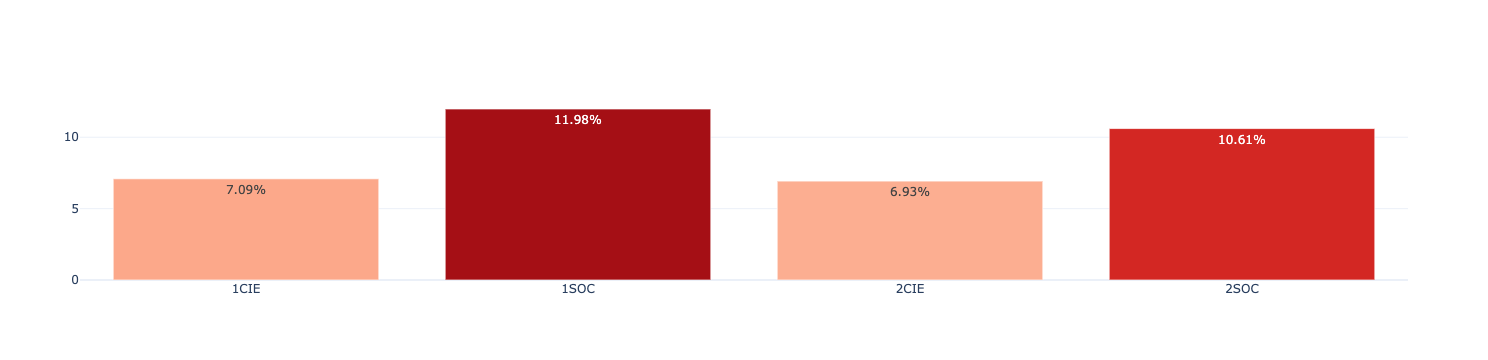

In [55]:
myplotly.bar_simple(dfc_BACH.index, dfc_BACH['absentismo'], colormap='Reds')

## CICLOS FORMATIVOS DE GRADO MEDIO

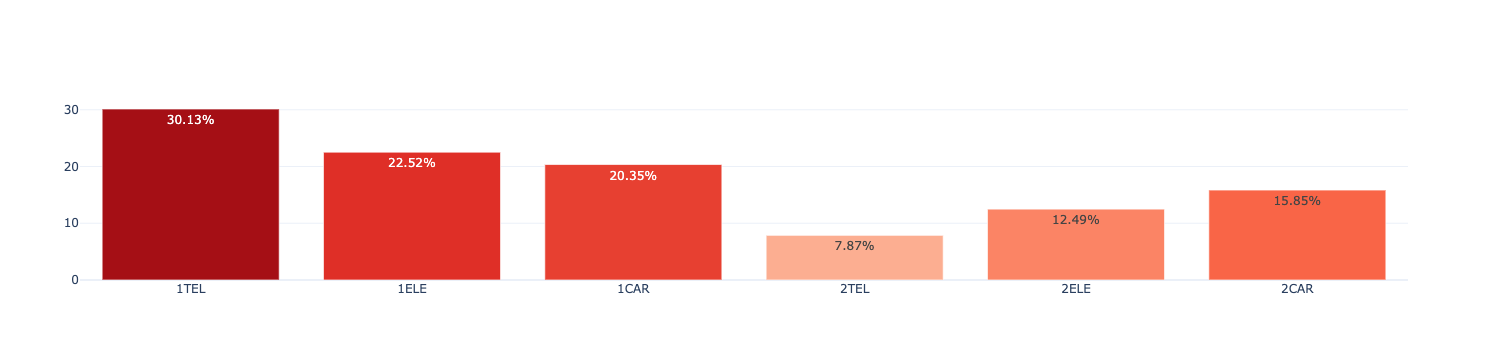

In [56]:
myplotly.bar_simple(dfc_CFGM.index, dfc_CFGM['absentismo'], colormap='Reds')

## CICLOS FORMATIVOS DE GRADO SUPERIOR

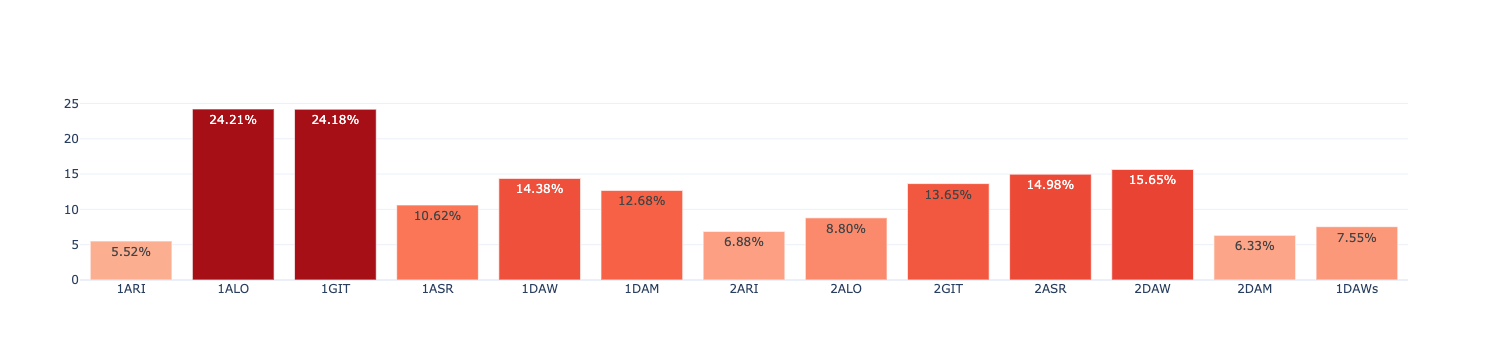

In [57]:
myplotly.bar_simple(dfc_CFGS.index, dfc_CFGS['absentismo'], colormap='Reds')

## GLOBAL

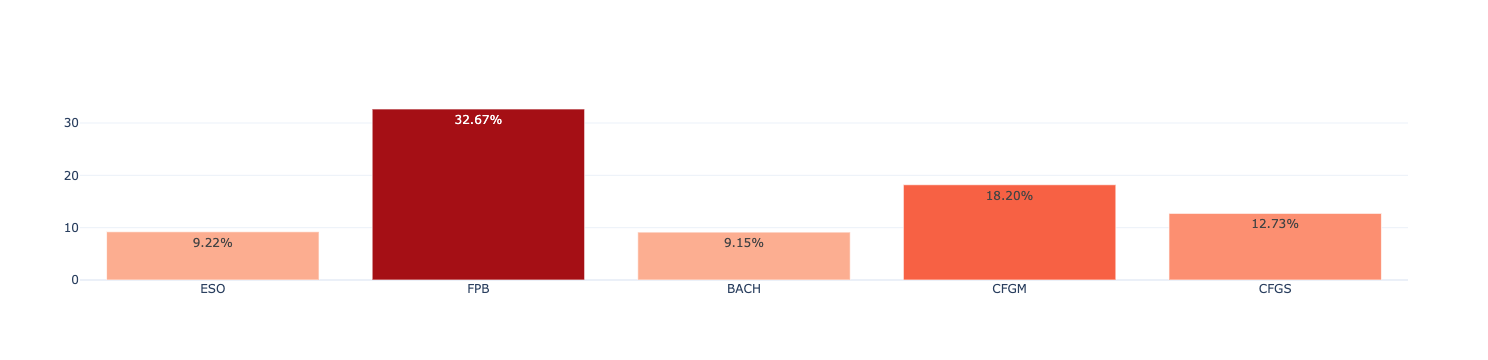

In [58]:
myplotly.bar_simple(dfc_summary.index, dfc_summary['absentismo'], colormap='Reds')

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

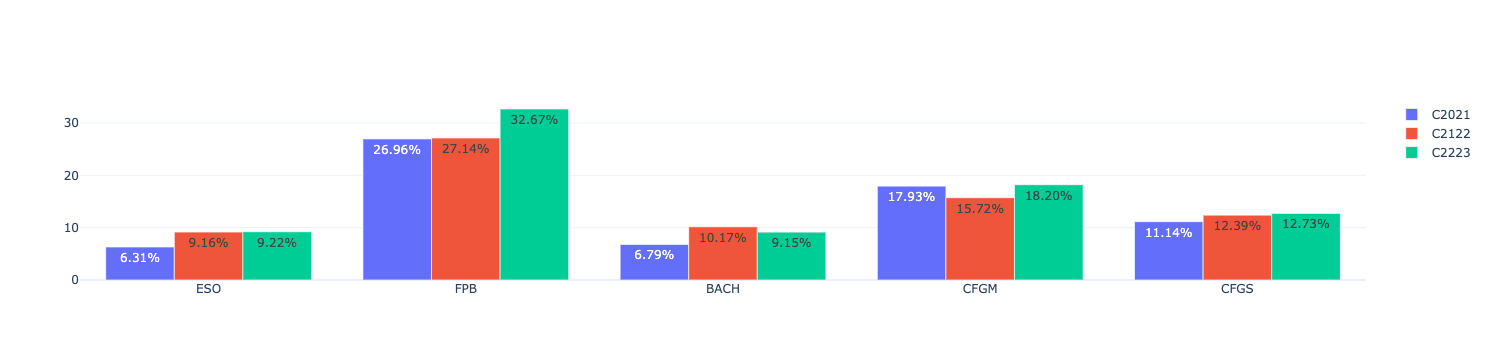

In [59]:
aux = df.groupby(['etapa', 'curso', 'evaluación']).mean().reset_index().set_index('etapa')
series = {year: aux.loc[stages].query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['absentismo'].values
          for year in years}

myplotly.cbar(stages, series)

In [60]:
mean_absence = dfc['absentismo'].mean()
display(HTML(f'''
<div class='alert alert-info' role="alert">
    Absentismo global medio: <b>{mean_absence:.2f}</b>%
</div>
'''))

In [61]:
if EVALUATION > 1:
    display(HTML('<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR'))

    aux = df_comp['absentismo_x'] - df_comp['absentismo_y']
    myplotly.dbar(aux.index, aux, inverted_colors=True)

# GESTIÓN DE LA CONVIVENCIA

## PARTES DE GESTIÓN

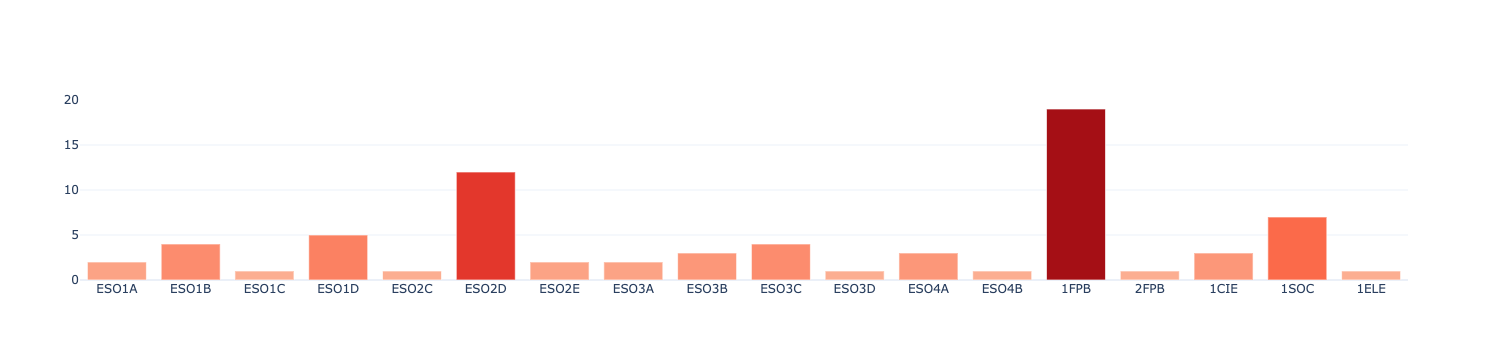

In [62]:
dfc_reports = dfc.query('partes > 0')['partes']
myplotly.bar_simple(dfc_reports.index, dfc_reports, colormap='Reds', is_percentage=False)

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

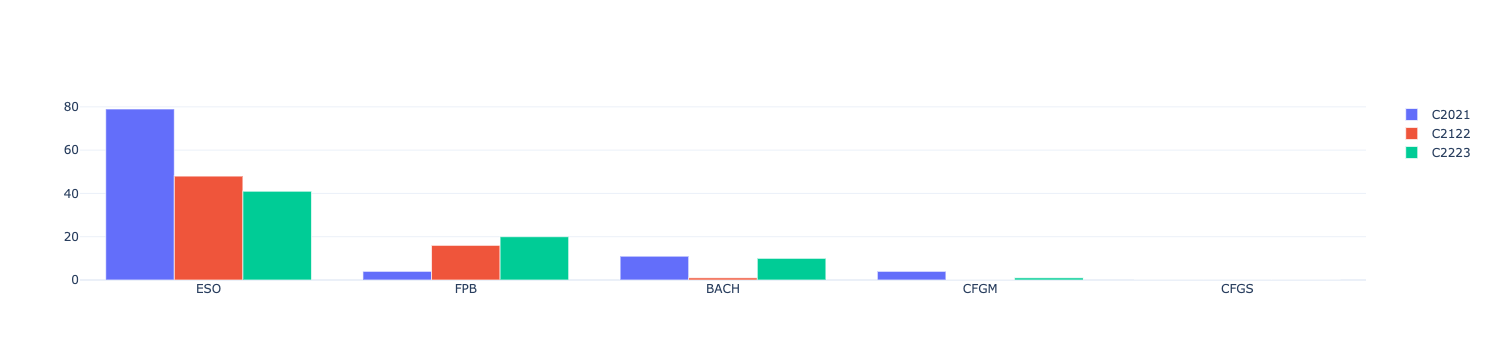

In [63]:
aux = df.groupby(['etapa', 'curso', 'evaluación']).sum().reset_index().set_index('etapa')
series = {year: aux.loc[stages].query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['partes'].values
          for year in years}

myplotly.cbar(stages, series, is_percentage=False)

In [64]:
total_reports = dfc_reports.sum()
display(HTML(f'''
<div class='alert alert-info' role="alert">
    Total de partes de gestión: <b>{total_reports:.0f}</b>
</div>
'''))

In [65]:
if EVALUATION > 1:
    display(HTML('<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR'))

    aux = df_comp['partes_x'] - df_comp['partes_y']
    myplotly.dbar(aux.index, aux, is_percentage=False, inverted_colors=True)

## SUSPENSIÓN DEL DERECHO DE ASISTENCIA

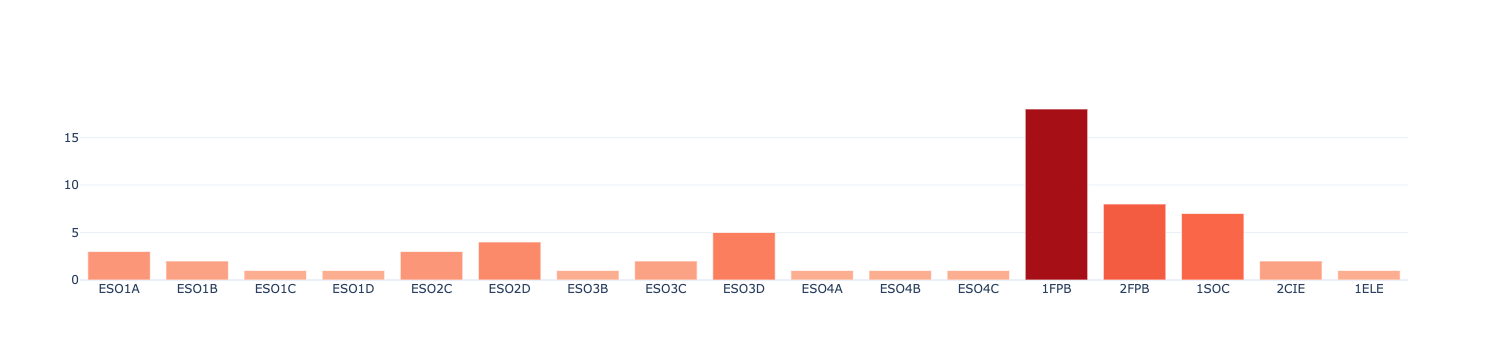

In [66]:
dfc_non_attendance = dfc.query('suspensión_asistencia > 0')['suspensión_asistencia']
myplotly.bar_simple(dfc_non_attendance.index, dfc_non_attendance, colormap='Reds', is_percentage=False)

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

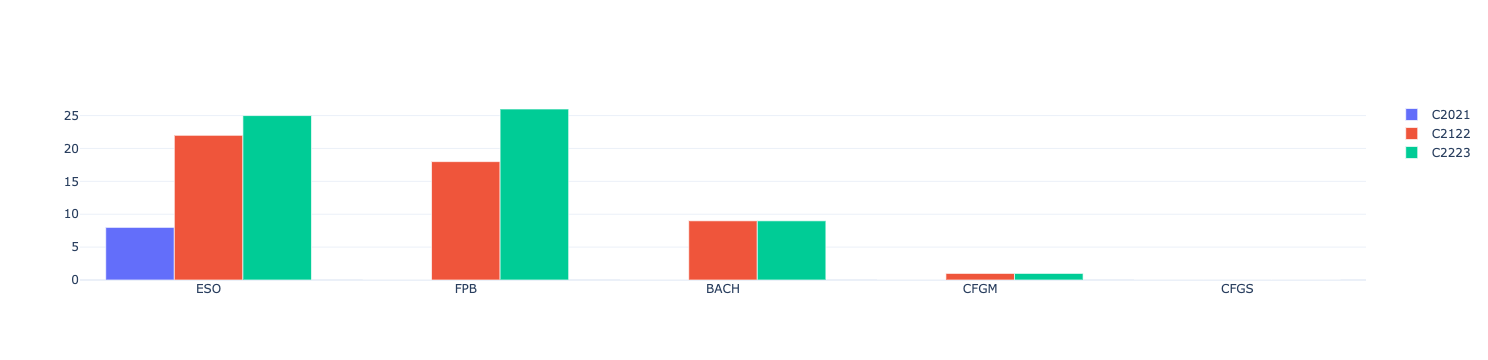

In [67]:
aux = df.groupby(['etapa', 'curso', 'evaluación']).sum().reset_index().set_index('etapa')
series = {year: aux.loc[stages].query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['suspensión_asistencia'].values
          for year in years}

myplotly.cbar(stages, series, is_percentage=False)

In [68]:
total_non_attendance = dfc_non_attendance.sum()
display(HTML(f'''
<div class='alert alert-info' role="alert">
    Total de partes de gestión con <b>suspensión</b> del derecho de asistencia: <b>{total_non_attendance:.0f}</b>
</div>
'''))

# RELACIÓN `éxito-competencias básicas`

> **NOTA**: Análisis únicamente con grupos de la ESO.

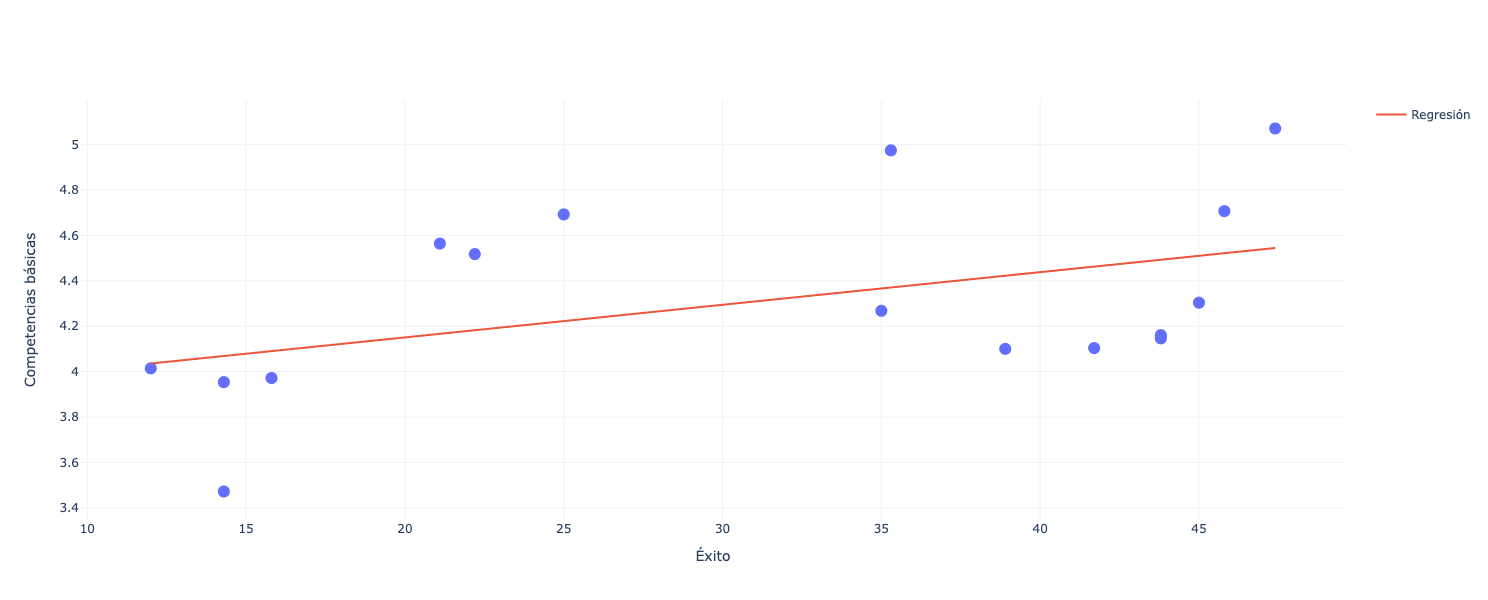

In [69]:
myplotly.scatter(dfc_ESO['éxito'], dfc_ESO['ccbb'], dfc_ESO.index,
        x_title='Éxito', y_title='Competencias básicas')

In [70]:
corr = dfc_ESO.corrwith(dfc['éxito'])['ccbb']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo éxito y alta adquisición de competencias básicas

In [71]:
dfc_ESO[(dfc_ESO['éxito'] < 20) & (dfc_ESO['ccbb'] > 5)][['éxito', 'ccbb']]

,éxito,ccbb
grupo,,


### Alto éxito y baja adquisición de competencias básicas

In [72]:
dfc_ESO[(dfc_ESO['éxito'] > 50) & (dfc_ESO['ccbb'] < 4)][['éxito', 'ccbb']]

,éxito,ccbb
grupo,,


# RELACIÓN `ratio-éxito`

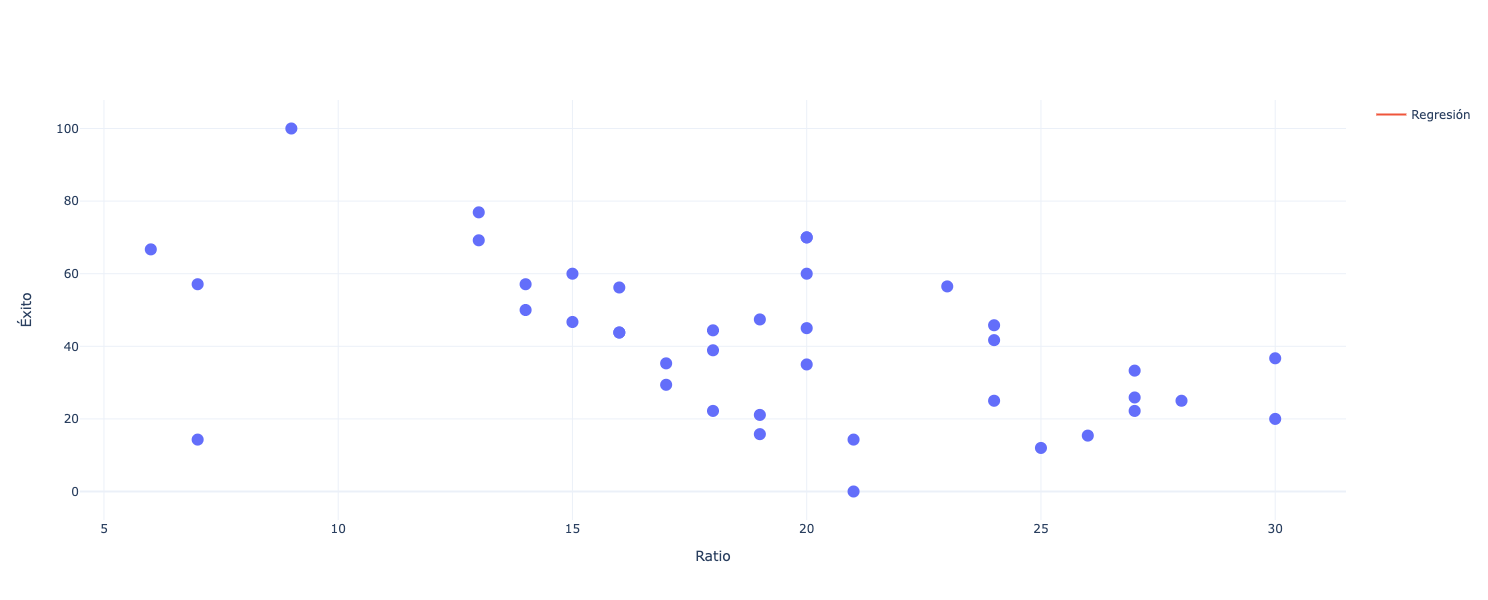

In [73]:
myplotly.scatter(dfc['ratio'], dfc['éxito'], dfc.index,
        x_title='Ratio', y_title='Éxito')

In [74]:
corr = dfc.corrwith(dfc['ratio'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Baja ratio y bajo éxito

In [75]:
dfc[(dfc['ratio'] < 20) & (dfc['éxito'] < 20)][['ratio', 'éxito']]

,ratio,éxito
grupo,,
ESO2E,7.0,14.3
ESO3B,19.0,15.8


### Alta ratio y alto éxito

In [76]:
dfc[(dfc['ratio'] > 25) & (dfc['éxito'] > 50)][['ratio', 'éxito']]

,ratio,éxito
grupo,,


# RELACIÓN `absentismo-éxito`

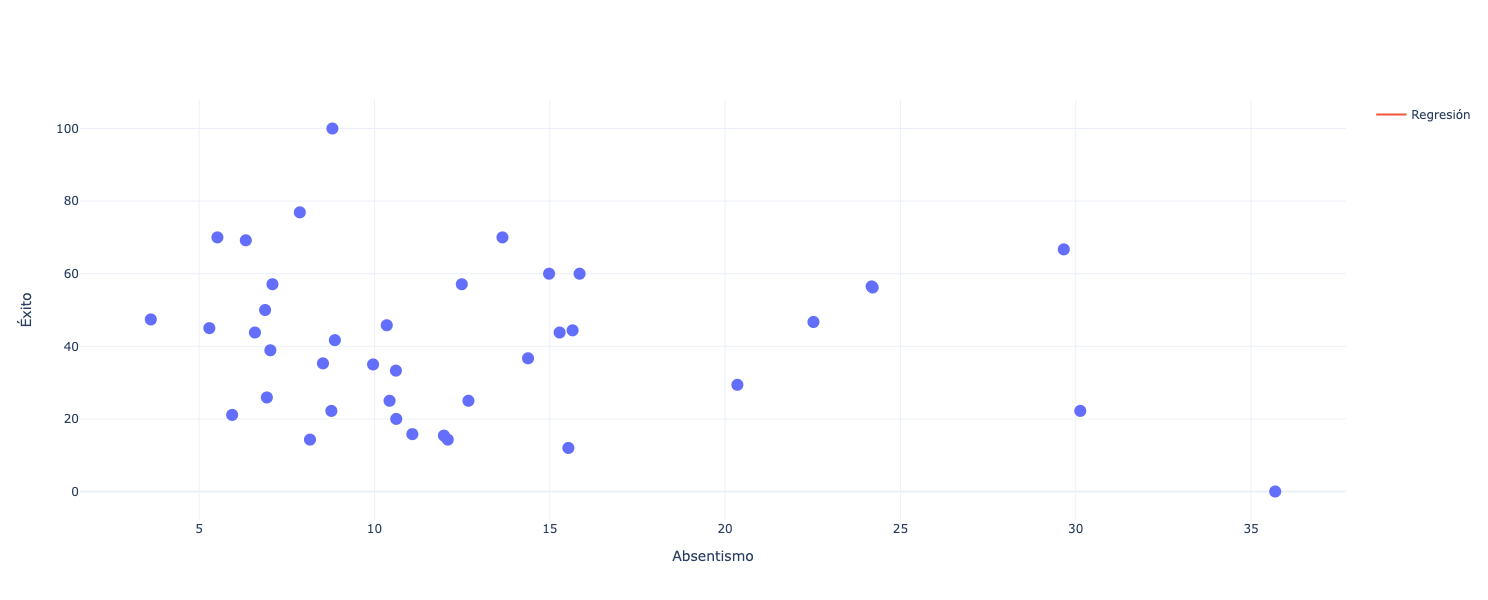

In [77]:
myplotly.scatter(dfc['absentismo'], dfc['éxito'], dfc.index,
        x_title='Absentismo', y_title='Éxito')

In [78]:
corr = dfc.corrwith(dfc['absentismo'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo absentismo y bajo éxito

In [79]:
dfc[(dfc['absentismo'] < 10) & (dfc['éxito'] < 15)][['absentismo', 'éxito']]

,absentismo,éxito
grupo,,
ESO2D,8.16,14.3


### Alto absentismo y alto éxito

In [80]:
dfc[(dfc['absentismo'] > 25) & (dfc['éxito'] > 50)][['absentismo', 'éxito']]

,absentismo,éxito
grupo,,
2FPB,29.66,66.7


# RELACIÓN `partes-éxito`

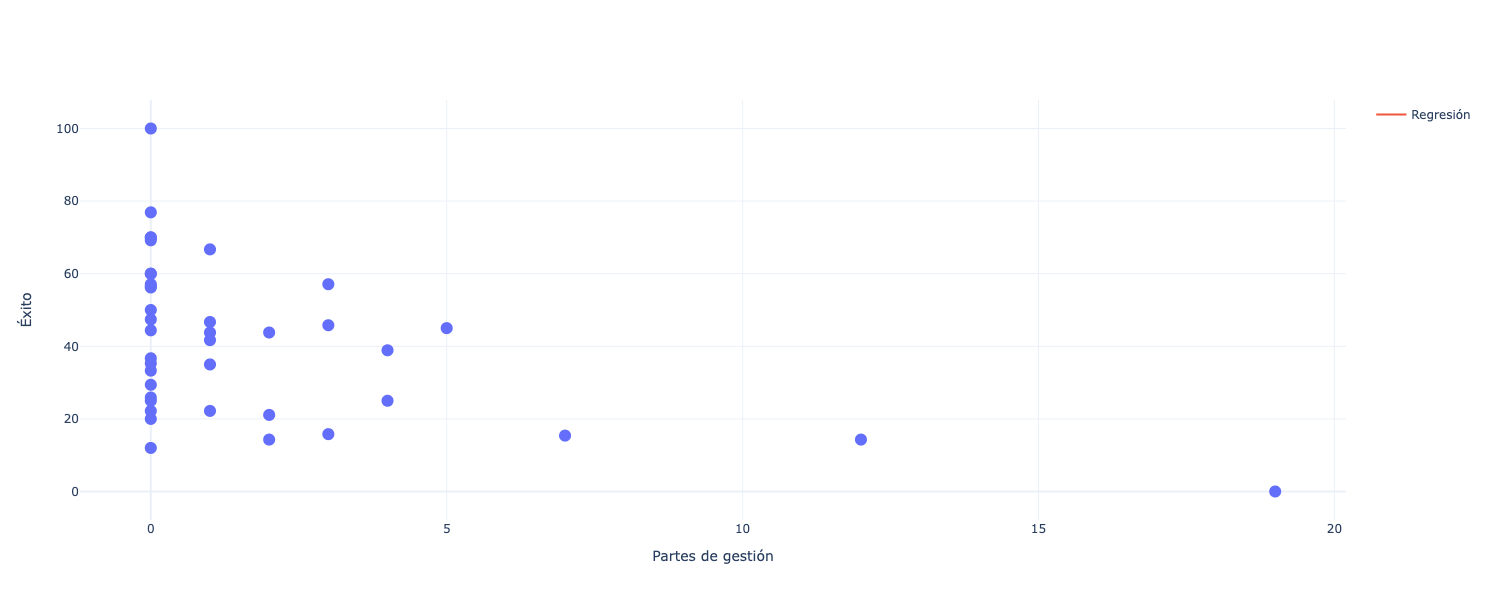

In [81]:
myplotly.scatter(dfc['partes'], dfc['éxito'], dfc.index,
        x_title='Partes de gestión', y_title='Éxito')

In [82]:
corr = dfc.corrwith(dfc['partes'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo número de partes y bajo éxito

In [83]:
dfc[(dfc['partes'] < 10) & (dfc['éxito'] < 10)][['partes', 'éxito']]

,partes,éxito
grupo,,


### Alto número de partes y alto éxito

In [84]:
dfc[(dfc['partes'] > 15) & (dfc['éxito'] > 30)][['partes', 'éxito']]

,partes,éxito
grupo,,


# GRUPOS MÁGICOS

> Son aquellos que tienen mejores valores de éxito escolar, menor absentismo y menos partes de gestión.

\begin{equation}
magic = 0.6 · success + 0.2 · e^{-absence} + 0.2 · e^{-reports}
\end{equation}

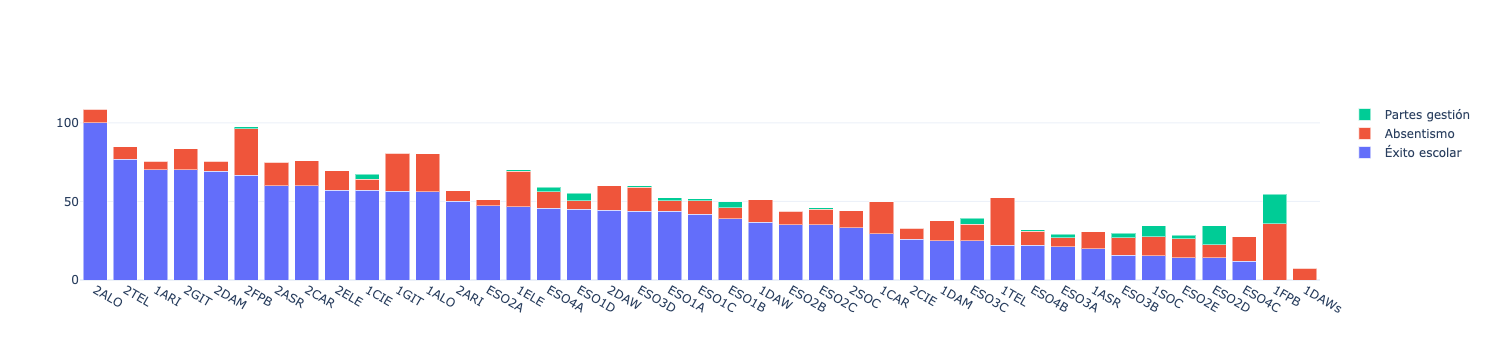

In [85]:
df2 = dfc.copy()
df2['magic'] = 0.6 * df2['éxito'] + 0.2 * \
    np.exp(-df2['absentismo']) + 0.2 * np.exp(-df2['partes'])
magic = df2.sort_values('magic', ascending=False)

series = {
    'Éxito escolar': magic['éxito'].values,
    'Absentismo': magic['absentismo'].values,
    'Partes gestión': magic['partes'].values
}

myplotly.cbar(magic.index, series, is_percentage=False, barmode='stack')

In [86]:
if EVALUATION > 1:
    display(HTML('<h1>PRUEBAS DE CERTIFICACIÓN PARA POBLACIÓN ESCOLAR</h1>'))
    myplotly.bar_pcei(labels[-1][0])